# Prediction notebook

This notebook allows replicating the figures and showcase how predictions can be made from the trained networks.

# Library loading and additional function definition

In [103]:
%matplotlib inline

import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import matplotlib, torch, time, h5py
import numpy as np
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error

import neuravi
import viscopy as vp

device = torch.device('cpu') #get_default_device()
print(device)

import mpltern, corner
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import matplotlib.gridspec as gridspec

###
### Functions for ternary plots
###

def polycorners(ncorners=3):
    '''
    Return 2D cartesian coordinates of a regular convex polygon of a specified
    number of corners.
    Args:
        ncorners (int, optional) number of corners for the polygon (default 3).
    Returns:
        (ncorners, 2) np.ndarray of cartesian coordinates of the polygon.
    '''

    center = np.array([0.5, 0.5])
    points = []

    for i in range(ncorners):
        angle = (float(i) / ncorners) * (np.pi * 2) + (np.pi / 2)
        x = center[0] + np.cos(angle) * 0.5
        y = center[1] + np.sin(angle) * 0.5
        points.append(np.array([x, y]))

    return np.array(points)

def bary2cart(bary, corners):
    '''
    Convert barycentric coordinates to cartesian coordinates given the
    cartesian coordinates of the corners.
    Args:
        bary (np.ndarray): barycentric coordinates to convert. If this matrix
            has multiple rows, each row is interpreted as an individual
            coordinate to convert.
        corners (np.ndarray): cartesian coordinates of the corners.
    Returns:
        2-column np.ndarray of cartesian coordinates for each barycentric
        coordinate provided.
    '''

    cart = None

    if len(bary.shape) > 1 and bary.shape[1] > 1:
        cart = np.array([np.sum(b / np.sum(b) * corners.T, axis=1) for b in bary])
    else:
        cart = np.sum(bary / np.sum(bary) * corners.T, axis=1)

    return cart


cpu


# Load dataset

In [2]:
path_data = "./data/DataSet_0p20val.hdf5"
path_raman = "./data/NKAS_Raman.hdf5"
path_density = "./data/NKAS_density.hdf5"
path_optical = "./data/NKAS_optical.hdf5"

ds = neuravi.data_loader(path_data,path_raman,path_density,path_optical,device)


/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


# Function to bag models

This object will help bagging results from 10 models and calling their predictions.

In [3]:
class models:
    """custom global model predictions

    """
    def __init__(self, path, name_models, device):
        
        self.device = device
        self.n_models = len(name_models)
        self.models = [None for _ in range(self.n_models)]
        
        for i in range(self.n_models):
            name = name_models[i]
            
            # Extract arch
            nb_layers = int(name[name.find("l")+1:name.find("_n")])
            nb_neurons = int(name[name.find("n")+1:name.rfind("_p")])
            p_drop = float(name[name.find("p")+1:name.rfind(".")])
            
            self.models[i] = neuravi.model(4,nb_neurons,nb_layers,ds.nb_channels_raman,p_drop=p_drop) 
            self.models[i].load_state_dict(torch.load(path+name,map_location='cpu'))
            self.models[i].eval()
            
    def predict(self,method,X, T=[1000.0], lbd= [500.0]):
        
        X = torch.Tensor(X).to(self.device)
        T = torch.Tensor(T).to(self.device)
        lbd = torch.Tensor(lbd).to(self.device)
        
        if method == "raman_pred":    
            out = np.zeros((len(X),850,self.n_models)) # problem is defined with a X raman shift of 850 values
            for i in range(self.n_models):
                out[:,:,i] = getattr(self.models[i],method)(X).cpu().detach().numpy()
            return out
        else:
            out = np.zeros((len(X),self.n_models))
            
        if method in frozenset(('ag', 'myega', 'am', 'cg', 'tvf')):
            for i in range(self.n_models):
                out[:,i] = getattr(self.models[i],method)(X,T).cpu().detach().numpy().reshape(-1)
        elif method == "sellmeier":
            for i in range(self.n_models):
                out[:,i] = getattr(self.models[i],method)(X,lbd).cpu().detach().numpy().reshape(-1)           
        else:
            for i in range(self.n_models):
                out[:,i] = getattr(self.models[i],method)(X).cpu().detach().numpy().reshape(-1)
        
        return out
                    

# Loading the models

In [4]:
path = "./model/best/"
name_list = pd.read_csv("./model/best/best_list.csv").loc[:,"name"]
neuralmodel = models(path, name_list, device)

# Test figure

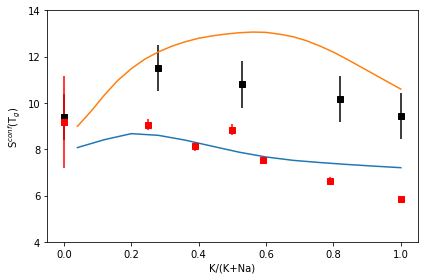

In [5]:
plt.xlabel("K/(K+Na)")
plt.ylabel("S$^{conf}$(T$_g$)")
plt.ylim(4,14)

plt.errorbar(np.array([0,0.28,0.53,0.82,1.0]),np.array([32.91,40.31,37.81,35.59,32.99])/7.0*2.0,
    yerr = 1.0, fmt="ks",
    label="Richet, 1984")

## endmember silicate
na2o = np.arange(0.,0.125,0.01)
k2o = 0.125-na2o
sio2 = np.ones(len(na2o))*0.75
al2o3 = np.ones(len(na2o))*0.125

X_visu_ = np.vstack([sio2,al2o3,na2o,k2o]).T
X_visu_.shape

plt.plot(X_visu_[:,3]/(X_visu_[:,2]+X_visu_[:,3]),neuralmodel.predict("sctg",X_visu_).mean(axis=1),label="NN model")

## endmember silicate
na2o = np.arange(0.,0.25,0.01)
k2o = 0.25-na2o
sio2 = np.ones(len(na2o))*0.75
al2o3 = np.zeros(len(na2o))

X_visu_ = np.vstack([sio2,al2o3,na2o,k2o]).T
X_visu_.shape

plt.plot(X_visu_[:,3]/(X_visu_[:,2]+X_visu_[:,3]),neuralmodel.predict("sctg",X_visu_).mean(axis=1),label="NN model silicates")


plt.xlabel("K/(K+Na)")
plt.ylabel("S$^{conf}$(T$_g$)")
plt.ylim(4,14)

plt.errorbar(np.array([0,0.25,0.39,0.50,0.59,0.79,1.00]),
             np.array([9.17,9.06,8.12,8.84,7.54,6.63,5.83]),
    yerr = np.array([2.,0.23,0.20,0.23,0.18,0.15,0.11]), fmt="s", color="r",
    label="Le Losq et al., 2017")

plt.tight_layout()

# Root-mean-squared-errors calculations

Between all datasets and their predictions.

In [6]:
criterion = torch.nn.MSELoss()

y_ag_train = neuralmodel.predict("ag",ds.x_visco_train,ds.T_visco_train)
y_ag_valid = neuralmodel.predict("ag",ds.x_visco_valid,ds.T_visco_valid)
y_ag_test = neuralmodel.predict("ag",ds.x_visco_test,ds.T_visco_test)

y_tvf_train = neuralmodel.predict("tvf",ds.x_visco_train,ds.T_visco_train)
y_tvf_valid = neuralmodel.predict("tvf",ds.x_visco_valid,ds.T_visco_valid)
y_tvf_test = neuralmodel.predict("tvf",ds.x_visco_test,ds.T_visco_test)

y_myega_train = neuralmodel.predict("myega",ds.x_visco_train,ds.T_visco_train)
y_myega_valid = neuralmodel.predict("myega",ds.x_visco_valid,ds.T_visco_valid)
y_myega_test = neuralmodel.predict("myega",ds.x_visco_test,ds.T_visco_test)

y_am_train = neuralmodel.predict("am",ds.x_visco_train,ds.T_visco_train)
y_am_valid = neuralmodel.predict("am",ds.x_visco_valid,ds.T_visco_valid)
y_am_test = neuralmodel.predict("am",ds.x_visco_test,ds.T_visco_test)

y_cg_train = neuralmodel.predict("cg",ds.x_visco_train,ds.T_visco_train)
y_cg_valid = neuralmodel.predict("cg",ds.x_visco_valid,ds.T_visco_valid)
y_cg_test = neuralmodel.predict("cg",ds.x_visco_test,ds.T_visco_test)

ag_after_train = np.sqrt(mean_squared_error(y_ag_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
ag_after_valid = np.sqrt(mean_squared_error(y_ag_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
ag_after_test = np.sqrt(mean_squared_error(y_ag_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('AG train loss after training {0:.2f}'.format(ag_after_train))
print('AG valid loss after training {0:.2f}'.format(ag_after_valid))
print('AG test loss after training {0:.2f}'.format(ag_after_test))
print('')

tvf_after_train = np.sqrt(mean_squared_error(y_tvf_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
tvf_after_valid = np.sqrt(mean_squared_error(y_tvf_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
tvf_after_test  = np.sqrt(mean_squared_error(y_tvf_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('TVF train loss after training {0:.2f}'.format(tvf_after_train))
print('TVF valid loss after training {0:.2f}'.format(tvf_after_valid))
print('TVF test loss after training {0:.2f}'.format(tvf_after_test))
print('')

myega_after_train = np.sqrt(mean_squared_error(y_myega_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
myega_after_valid = np.sqrt(mean_squared_error(y_myega_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
myega_after_test = np.sqrt(mean_squared_error(y_myega_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('myega train loss after training {0:.2f}'.format(myega_after_train))
print('myega valid loss after training {0:.2f}'.format(myega_after_valid))
print('myega test loss after training {0:.2f}'.format(myega_after_test))
print('')

am_after_train = np.sqrt(mean_squared_error(y_am_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
am_after_valid = np.sqrt(mean_squared_error(y_am_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
am_after_test = np.sqrt(mean_squared_error(y_am_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('am train loss after training {0:.2f}'.format(am_after_train))
print('am valid loss after training {0:.2f}'.format(am_after_valid))
print('am test loss after training {0:.2f}'.format(am_after_test))
print('')

cg_after_train = np.sqrt(mean_squared_error(y_cg_train.mean(axis=1), ds.y_visco_train.detach().numpy()))
cg_after_valid = np.sqrt(mean_squared_error(y_cg_valid.mean(axis=1), ds.y_visco_valid.detach().numpy()))
cg_after_test = np.sqrt(mean_squared_error(y_cg_test.mean(axis=1), ds.y_visco_test.detach().numpy()))

print('cg train loss after training {0:.2f}'.format(cg_after_train))
print('cg valid loss after training {0:.2f}'.format(cg_after_valid))
print('cg test loss after training {0:.2f}'.format(cg_after_test))
print('')

# Now we calculate on density and refractive index
ese_density_train = np.sqrt(mean_squared_error(ds.y_density_train.cpu().detach().numpy(),
                           neuralmodel.predict("density",ds.x_density_train).mean(axis=1)))
ese_density_valid = np.sqrt(mean_squared_error(ds.y_density_valid.cpu().detach().numpy(),
                           neuralmodel.predict("density",ds.x_density_valid).mean(axis=1)))
ese_density_test = np.sqrt(mean_squared_error(ds.y_density_test.cpu().detach().numpy(),
                           neuralmodel.predict("density",ds.x_density_test).mean(axis=1)))

ese_ri_train = np.sqrt(mean_squared_error(ds.y_ri_train.cpu().detach().numpy(),
                           neuralmodel.predict("sellmeier",ds.x_ri_train,lbd=ds.lbd_ri_train).mean(axis=1)))
ese_ri_valid = np.sqrt(mean_squared_error(ds.y_ri_valid.cpu().detach().numpy(),
                           neuralmodel.predict("sellmeier",ds.x_ri_valid,lbd=ds.lbd_ri_valid).mean(axis=1)))
ese_ri_test = np.sqrt(mean_squared_error(ds.y_ri_test.cpu().detach().numpy(),
                           neuralmodel.predict("sellmeier",ds.x_ri_test,lbd=ds.lbd_ri_test).mean(axis=1)))

print('density train loss after training {0:.3f}'.format(ese_density_train))
print('density valid loss after training {0:.3f}'.format(ese_density_valid))
print('density test loss after training {0:.3f}'.format(ese_density_test))
print('')

print('refractive index train loss after training {0:.3f}'.format(ese_ri_train))
print('refractive index valid loss after training {0:.3f}'.format(ese_ri_valid))
print('refractive index test loss after training {0:.3f}'.format(ese_ri_test))
print('')


AG train loss after training 0.25
AG valid loss after training 0.30
AG test loss after training 0.46

TVF train loss after training 0.24
TVF valid loss after training 0.35
TVF test loss after training 0.45

myega train loss after training 0.25
myega valid loss after training 0.39
myega test loss after training 0.46

am train loss after training 0.24
am valid loss after training 0.36
am test loss after training 0.46

cg train loss after training 0.22
cg valid loss after training 0.36
cg test loss after training 0.45

density train loss after training 0.007
density valid loss after training 0.014
density test loss after training 0.009

refractive index train loss after training 0.003
refractive index valid loss after training 0.003
refractive index test loss after training 0.005



# Figure 2

Viscosity predictions for melts with ~66 mol% silica and different Al/Si ratios.

In [7]:
df2 = pd.read_csv("./data/data_for_post_analyses.csv")
nks = df2.loc[df2.ref=="see LL2017b",:].reset_index()
Jd = df2.loc[df2.ref=="R2019",:].reset_index()
NAK6509 = df2.loc[df2.ref=="TS",:].reset_index()

def plot_viscocurve(ax,dts,method = "ag",color="k",marker="s",linestyle="-"):
    x_inter = np.arange(dts.loc[:,"T"].min()-50,dts.loc[:,"T"].max()+50,1.0)
    ax.plot(10**4/x_inter,
             neuralmodel.predict(method,
                                 torch.Tensor(dts.loc[0,"sio2":"k2o"].values.astype('float')*np.ones((len(x_inter),4))).to(device),
                                 torch.Tensor(x_inter.reshape(-1,1)).to(device)).mean(axis=1),
            color=color, linestyle=linestyle
        )
    return ax

def prepare_data_fig2(neuralmodel,sio2,al2o3,alkalis, xk_ = np.arange(0,1,0.01), T_ = np.arange(650,2000,1.0)):
    """prepare xk mapping for surface plot of figure 2"""
    xk_plot = []
    T_plot = []
    for count,value in enumerate(xk_):
        X__ = np.vstack([sio2*np.ones(len(T_)),
                         al2o3*np.ones(len(T_)),
                         alkalis*(1-value*np.ones(len(T_))),
                         alkalis*value*np.ones(len(T_))]).T
        if count == 0:
            xk_plot = value*np.ones(len(T_))
            T_plot = T_.copy()
            n_plot = neuralmodel.predict("cg",X__,np.array(T_).reshape(-1,1)).mean(axis=-1)
        else:
            xk_plot = np.vstack((xk_plot,value*np.ones(len(T_))))
            T_plot = np.vstack((T_plot,T_))
            n_plot = np.vstack((n_plot,neuralmodel.predict("ag",X__,np.array(T_).reshape(-1,1)).mean(axis=-1)))
    
    return xk_plot, T_plot, n_plot

In [8]:
xk_plot_NKS, T_plot_NKS, n_plot_NKS  = prepare_data_fig2(neuralmodel,0.67,0.0,0.33)
xk_plot_Jad, T_plot_Jad, n_plot_Jad = prepare_data_fig2(neuralmodel,0.67,0.165,0.165,T_ = np.arange(1050,2000,1.0))
xk_plot_6509, T_plot_6509, n_plot_6509 = prepare_data_fig2(neuralmodel,0.66,0.09,0.25,T_ = np.arange(750,2000,1.0))

/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


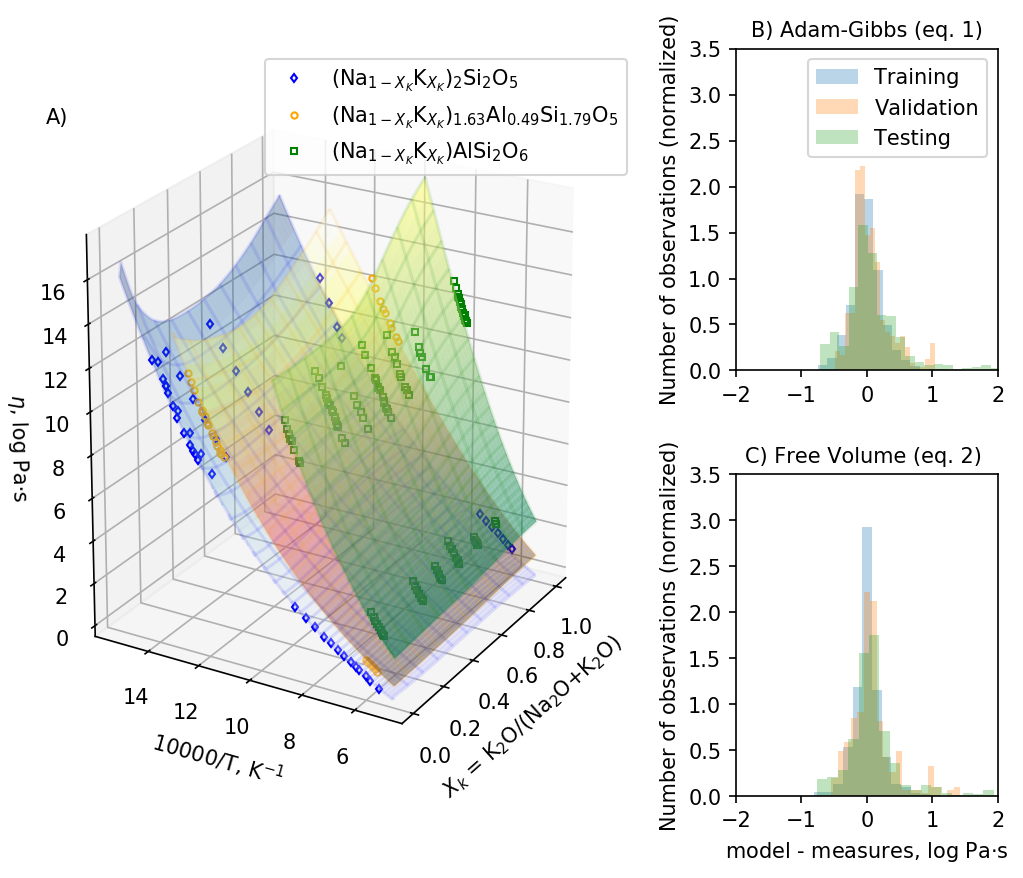

In [9]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(constrained_layout=True,figsize=(7,6),dpi=150)

spec2 = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)
ax = fig.add_subplot(spec2[:, 0:2], projection = "3d")
ax2 = fig.add_subplot(spec2[0, 2])
ax3 = fig.add_subplot(spec2[1, 2])

ax.plot(nks.k2o/(nks.k2o+nks.na2o),
        10000/nks.T_K,nks.viscosity,color="blue",marker="d",markerfacecolor="none",linestyle="",
        markersize = 3,label="(Na$_{1-X_K}$K$_{X_K}$)$_2$Si$_2$O$_5$")

ax.plot(NAK6509.k2o/(NAK6509.k2o+NAK6509.na2o),
        10000/NAK6509.T_K,NAK6509.viscosity,color="orange",marker="o",markerfacecolor="none",linestyle="",
        markersize = 3,label="(Na$_{1-X_K}$K$_{X_K}$)$_{1.63}$Al$_{0.49}$Si$_{1.79}}$O$_5$")

ax.plot(Jd.k2o/(Jd.k2o+Jd.na2o),
        10000/Jd.T_K,Jd.viscosity,color="green",marker="s",markerfacecolor="none",linestyle="",
        markersize = 3,label="(Na$_{1-X_K}$K$_{X_K}$)AlSi$_2$O$_6$")

ax.plot_surface(xk_plot_NKS,10000/T_plot_NKS,n_plot_NKS, alpha=0.3, cmap='Blues')
ax.plot_surface(xk_plot_Jad,10000/T_plot_Jad,n_plot_Jad, alpha=0.5, cmap='summer')
ax.plot_surface(xk_plot_6509,10000/T_plot_6509,n_plot_6509, alpha=0.3, cmap='hot')

ax.plot_wireframe(xk_plot_NKS,10000/T_plot_NKS,n_plot_NKS, color = "b", alpha=0.1 , rstride=10, cstride=40)
ax.plot_wireframe(xk_plot_Jad,10000/T_plot_Jad,n_plot_Jad, color = "green", alpha=0.1, rstride=10, cstride=40, cmap='summer')
ax.plot_wireframe(xk_plot_6509,10000/T_plot_6509,n_plot_6509, color = "orange", alpha=0.1, rstride=10, cstride=40, cmap='hot')

ax.set_ylabel("10000/T, K$^{-1}$")
ax.set_xlabel(r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)")
ax.set_zlabel("$\eta$, log Pa$\cdot$s")

ax2.hist(y_ag_train.mean(axis=1)-ds.y_visco_train.detach().numpy().ravel(),bins=20,alpha=0.3,density=True,
         label="Training")
ax2.hist(y_ag_valid.mean(axis=1)-ds.y_visco_valid.detach().numpy().ravel(),bins=20,alpha=0.3,density=True,
         label="Validation")
ax2.hist(y_ag_test.mean(axis=1)-ds.y_visco_test.detach().numpy().ravel(),bins=20,alpha=0.3,density=True,
         label="Testing")
ax2.set_xlim(-2,2)

ax3.hist(y_cg_train.mean(axis=1)-ds.y_visco_train.detach().numpy().ravel(),
         bins=20,alpha=0.3,density=True,label="Train.")
ax3.hist(y_cg_valid.mean(axis=1)-ds.y_visco_valid.detach().numpy().ravel(),
         bins=20,alpha=0.3,density=True,label="Valid.")
ax3.hist(y_cg_test.mean(axis=1)-ds.y_visco_test.detach().numpy().ravel(),
         bins=20,alpha=0.3,density=True,label="Test.")
ax3.set_xlim(-2,2)

ax3.set_xlabel("model - measures, log Pa$\cdot$s")
ax2.set_ylabel("Number of observations (normalized)")
ax3.set_ylabel("Number of observations (normalized)")

ax2.set_ylim(0,3.5)
ax3.set_ylim(0,3.5)

ax.annotate("A)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")
#ax2.title("B) AG - Adam-Gibbs ",xy=(0.05,0.9),xycoords="axes fraction",ha="left")
#ax3.title("C) CG - Free Volume ",xy=(0.05,0.9),xycoords="axes fraction",ha="left")
ax2.set_title("B) Adam-Gibbs (eq. 1)",fontsize=10)
ax3.set_title("C) Free Volume (eq. 2) ",fontsize=10)

ax.view_init(20, 210)

plt.tight_layout()

ax.legend(loc="best")
ax2.legend(loc="best")

plt.savefig("./figures/Figure2.png")

# Supplementary: comparison of viscosity predictions from all equations

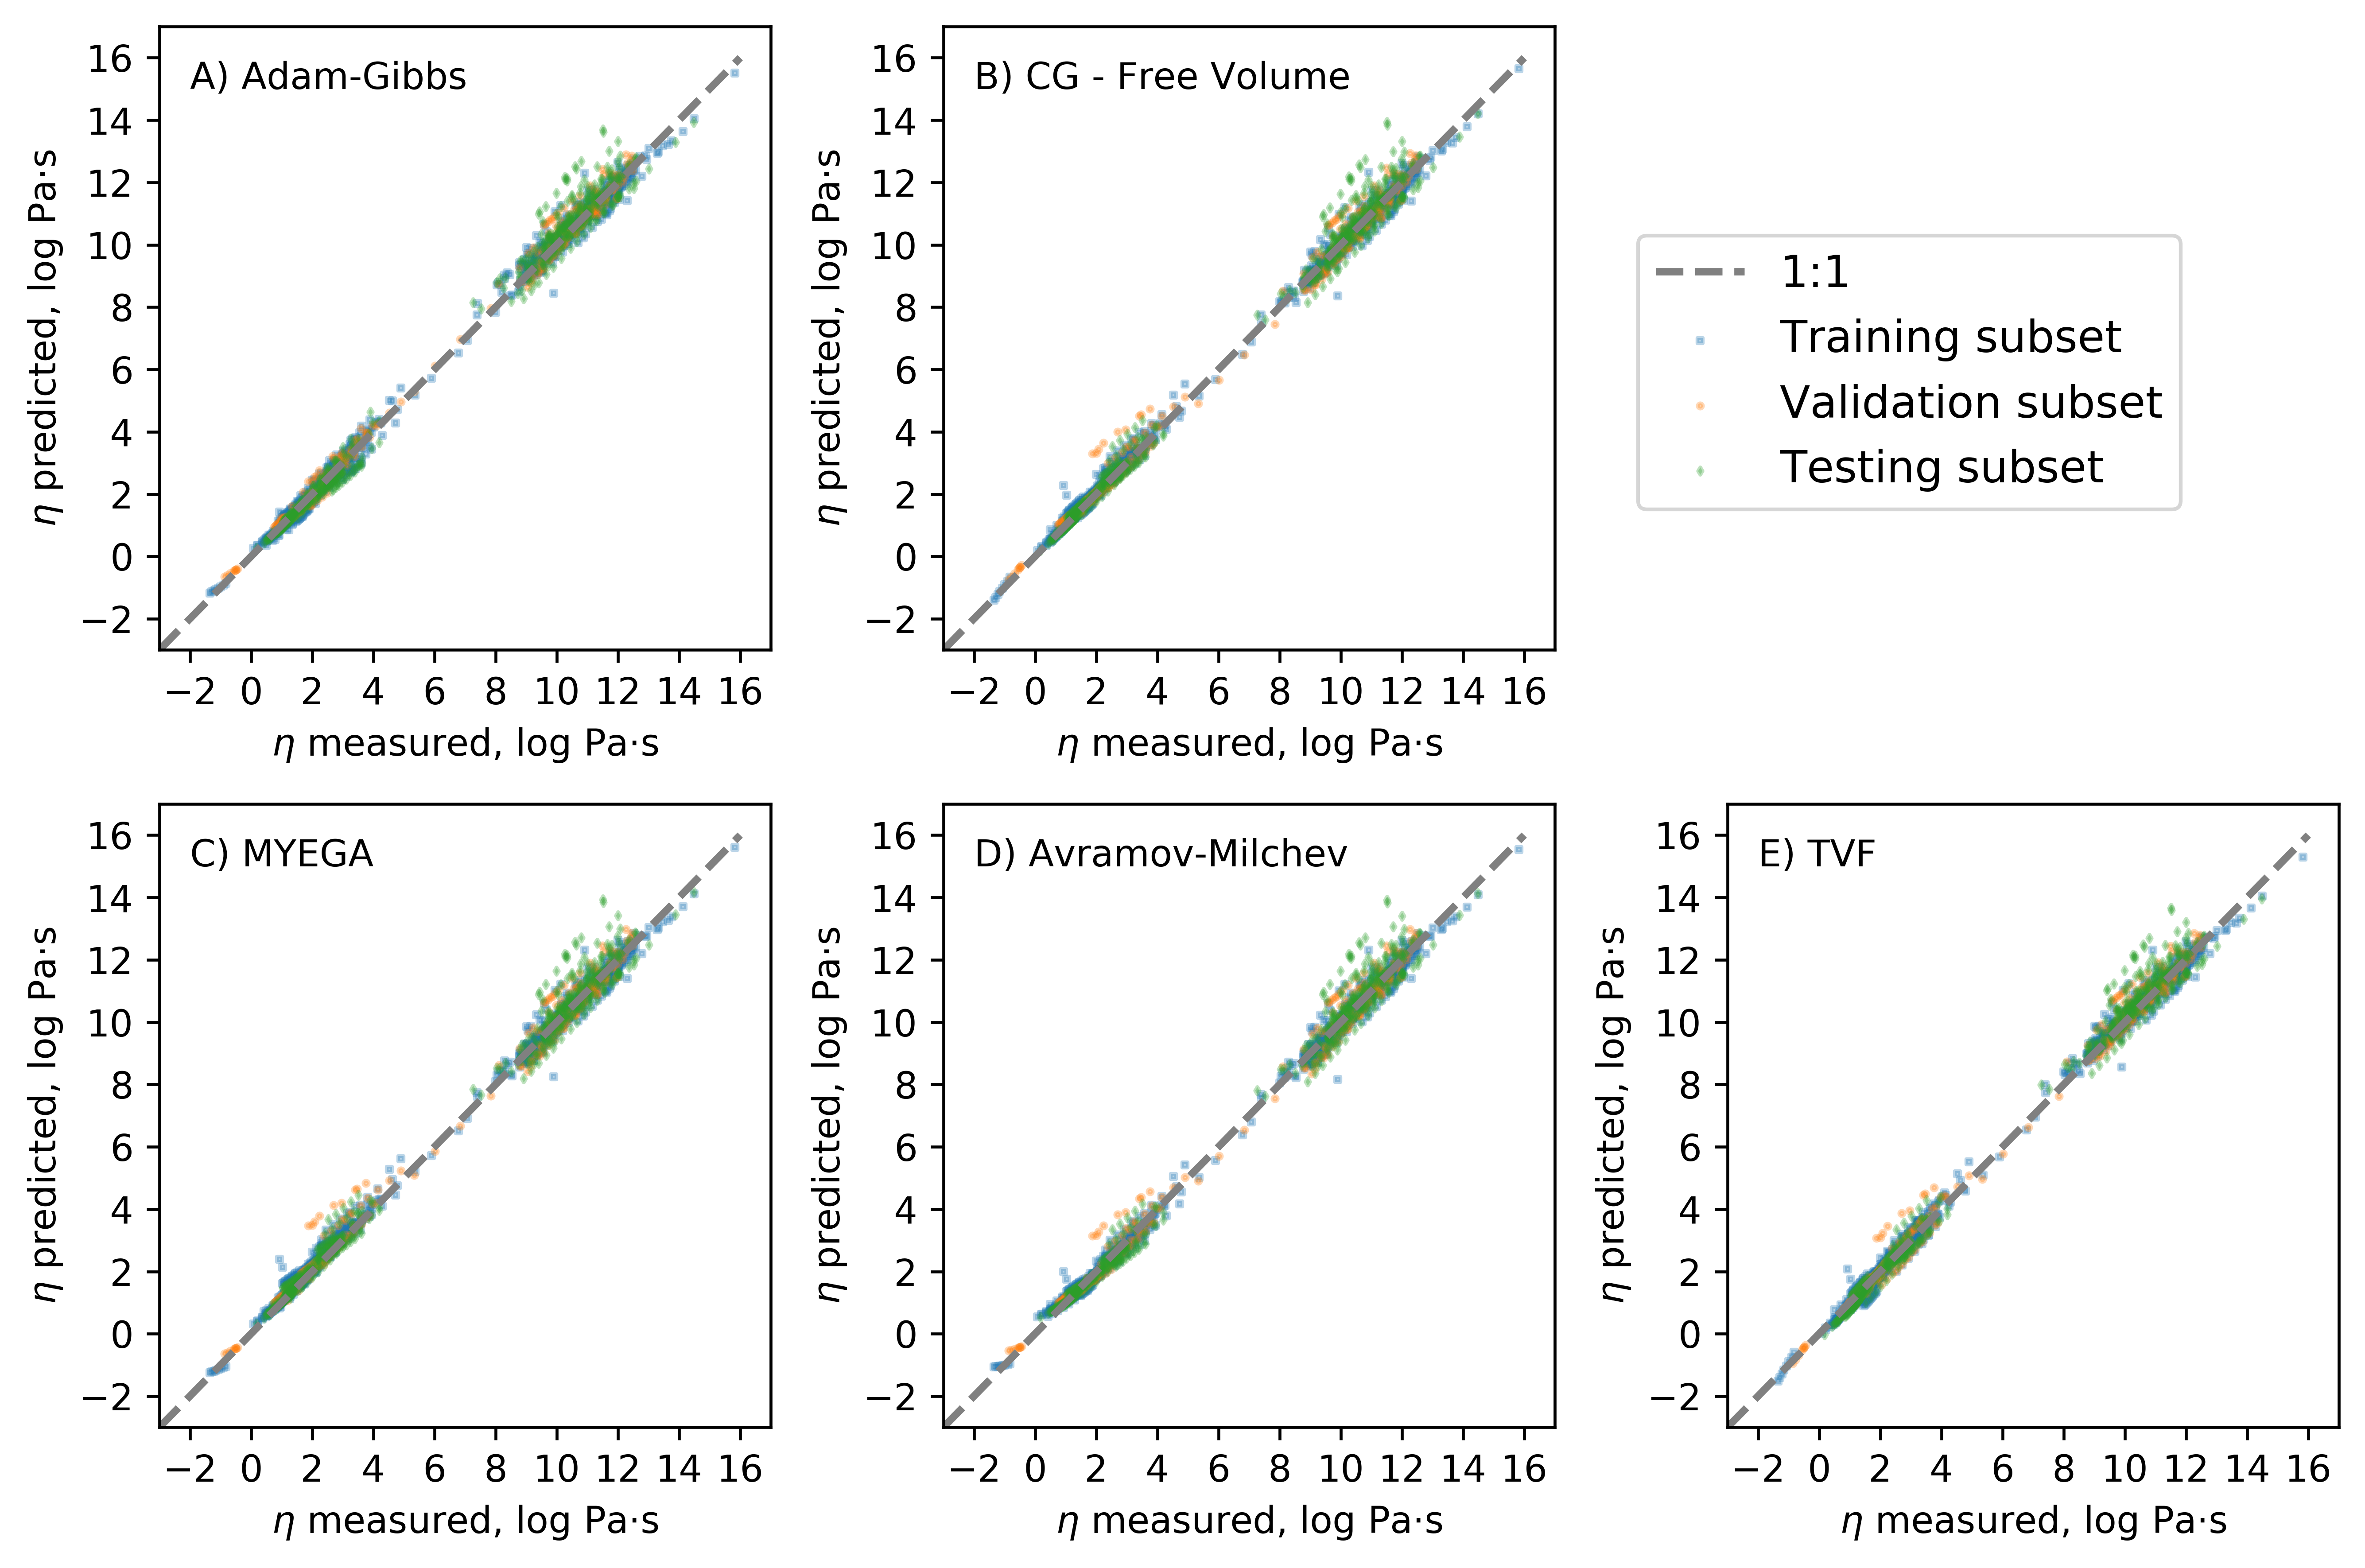

In [10]:
plt.figure(figsize=(9,6),dpi=600)

plt.subplot(2,3,1)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_ag_train.mean(axis=1),marker="s",s=2,alpha=0.3,label="Train")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_ag_valid.mean(axis=1),marker="o",s=2,alpha=0.3,label="Valid")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_ag_test.mean(axis=1),marker="d",s=2,alpha=0.3,label="Test")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2)

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.xticks(np.arange(-2,18,2))
plt.yticks(np.arange(-2,18,2))

plt.xlabel("$\eta$ measured, log Pa$\cdot$s")
plt.ylabel("$\eta$ predicted, log Pa$\cdot$s")

plt.annotate("A) Adam-Gibbs",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.subplot(2,3,4)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_myega_train.mean(axis=1),marker="s",s=2,alpha=0.3,label="Train")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_myega_valid.mean(axis=1),marker="o",s=2,alpha=0.3,label="Valid")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_myega_test.mean(axis=1),marker="d",s=2,alpha=0.3,label="Test")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2,label="1:1")

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.xticks(np.arange(-2,18,2))
plt.yticks(np.arange(-2,18,2))
plt.xlabel("$\eta$ measured, log Pa$\cdot$s")
plt.ylabel("$\eta$ predicted, log Pa$\cdot$s")
plt.annotate("C) MYEGA",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.subplot(2,3,5)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_am_train.mean(axis=1),marker="s",s=2,alpha=0.3,label="Training data subset")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_am_valid.mean(axis=1),marker="o",s=2,alpha=0.3,label="Validation data subset\n(used to stop training)")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_am_test.mean(axis=1),marker="d",s=2,alpha=0.3,label="Testing data subset\n(never seen during training)")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2,label="1:1")

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.xticks(np.arange(-2,18,2))
plt.yticks(np.arange(-2,18,2))

plt.xlabel("$\eta$ measured, log Pa$\cdot$s")
plt.ylabel("$\eta$ predicted, log Pa$\cdot$s")
plt.annotate("D) Avramov-Milchev ",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.subplot(2,3,6)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_tvf_train.mean(axis=1),marker="s",s=2,alpha=0.3,label="Training data subset")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_tvf_valid.mean(axis=1),marker="o",s=2,alpha=0.3,label="Validation data subset\n(used to stop training)")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_tvf_test.mean(axis=1),marker="d",s=2,alpha=0.3,label="Testing data subset\n(never seen during training)")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2,label="1:1")

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.xticks(np.arange(-2,18,2))
plt.yticks(np.arange(-2,18,2))

plt.xlabel("$\eta$ measured, log Pa$\cdot$s")
plt.ylabel("$\eta$ predicted, log Pa$\cdot$s")
plt.annotate("E) TVF ",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.subplot(2,3,2)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_cg_train.mean(axis=1),marker="s",s=2,alpha=0.3,
            label="Training subset")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_cg_valid.mean(axis=1),marker="o",s=2,alpha=0.3,
            label="Validation subset")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_cg_test.mean(axis=1),marker="d",s=2,alpha=0.3,
            label="Testing subset")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2,label="1:1")

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.xticks(np.arange(-2,18,2))
plt.yticks(np.arange(-2,18,2))

plt.xlabel("$\eta$ measured, log Pa$\cdot$s")
plt.ylabel("$\eta$ predicted, log Pa$\cdot$s")
plt.annotate("B) CG - Free Volume ",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.tight_layout()

plt.legend(fontsize=12, bbox_to_anchor=(1.1,0.7))

plt.savefig("./figures/Supp_compvisco.png")

# Supplementary figure : behavior at fixed Al/M ratios

This figure is only present in the notebook, it allows us to perform a visual inspection > predicted entropy and fragility should vary smoothly.

Checking shape...
(50, 4)


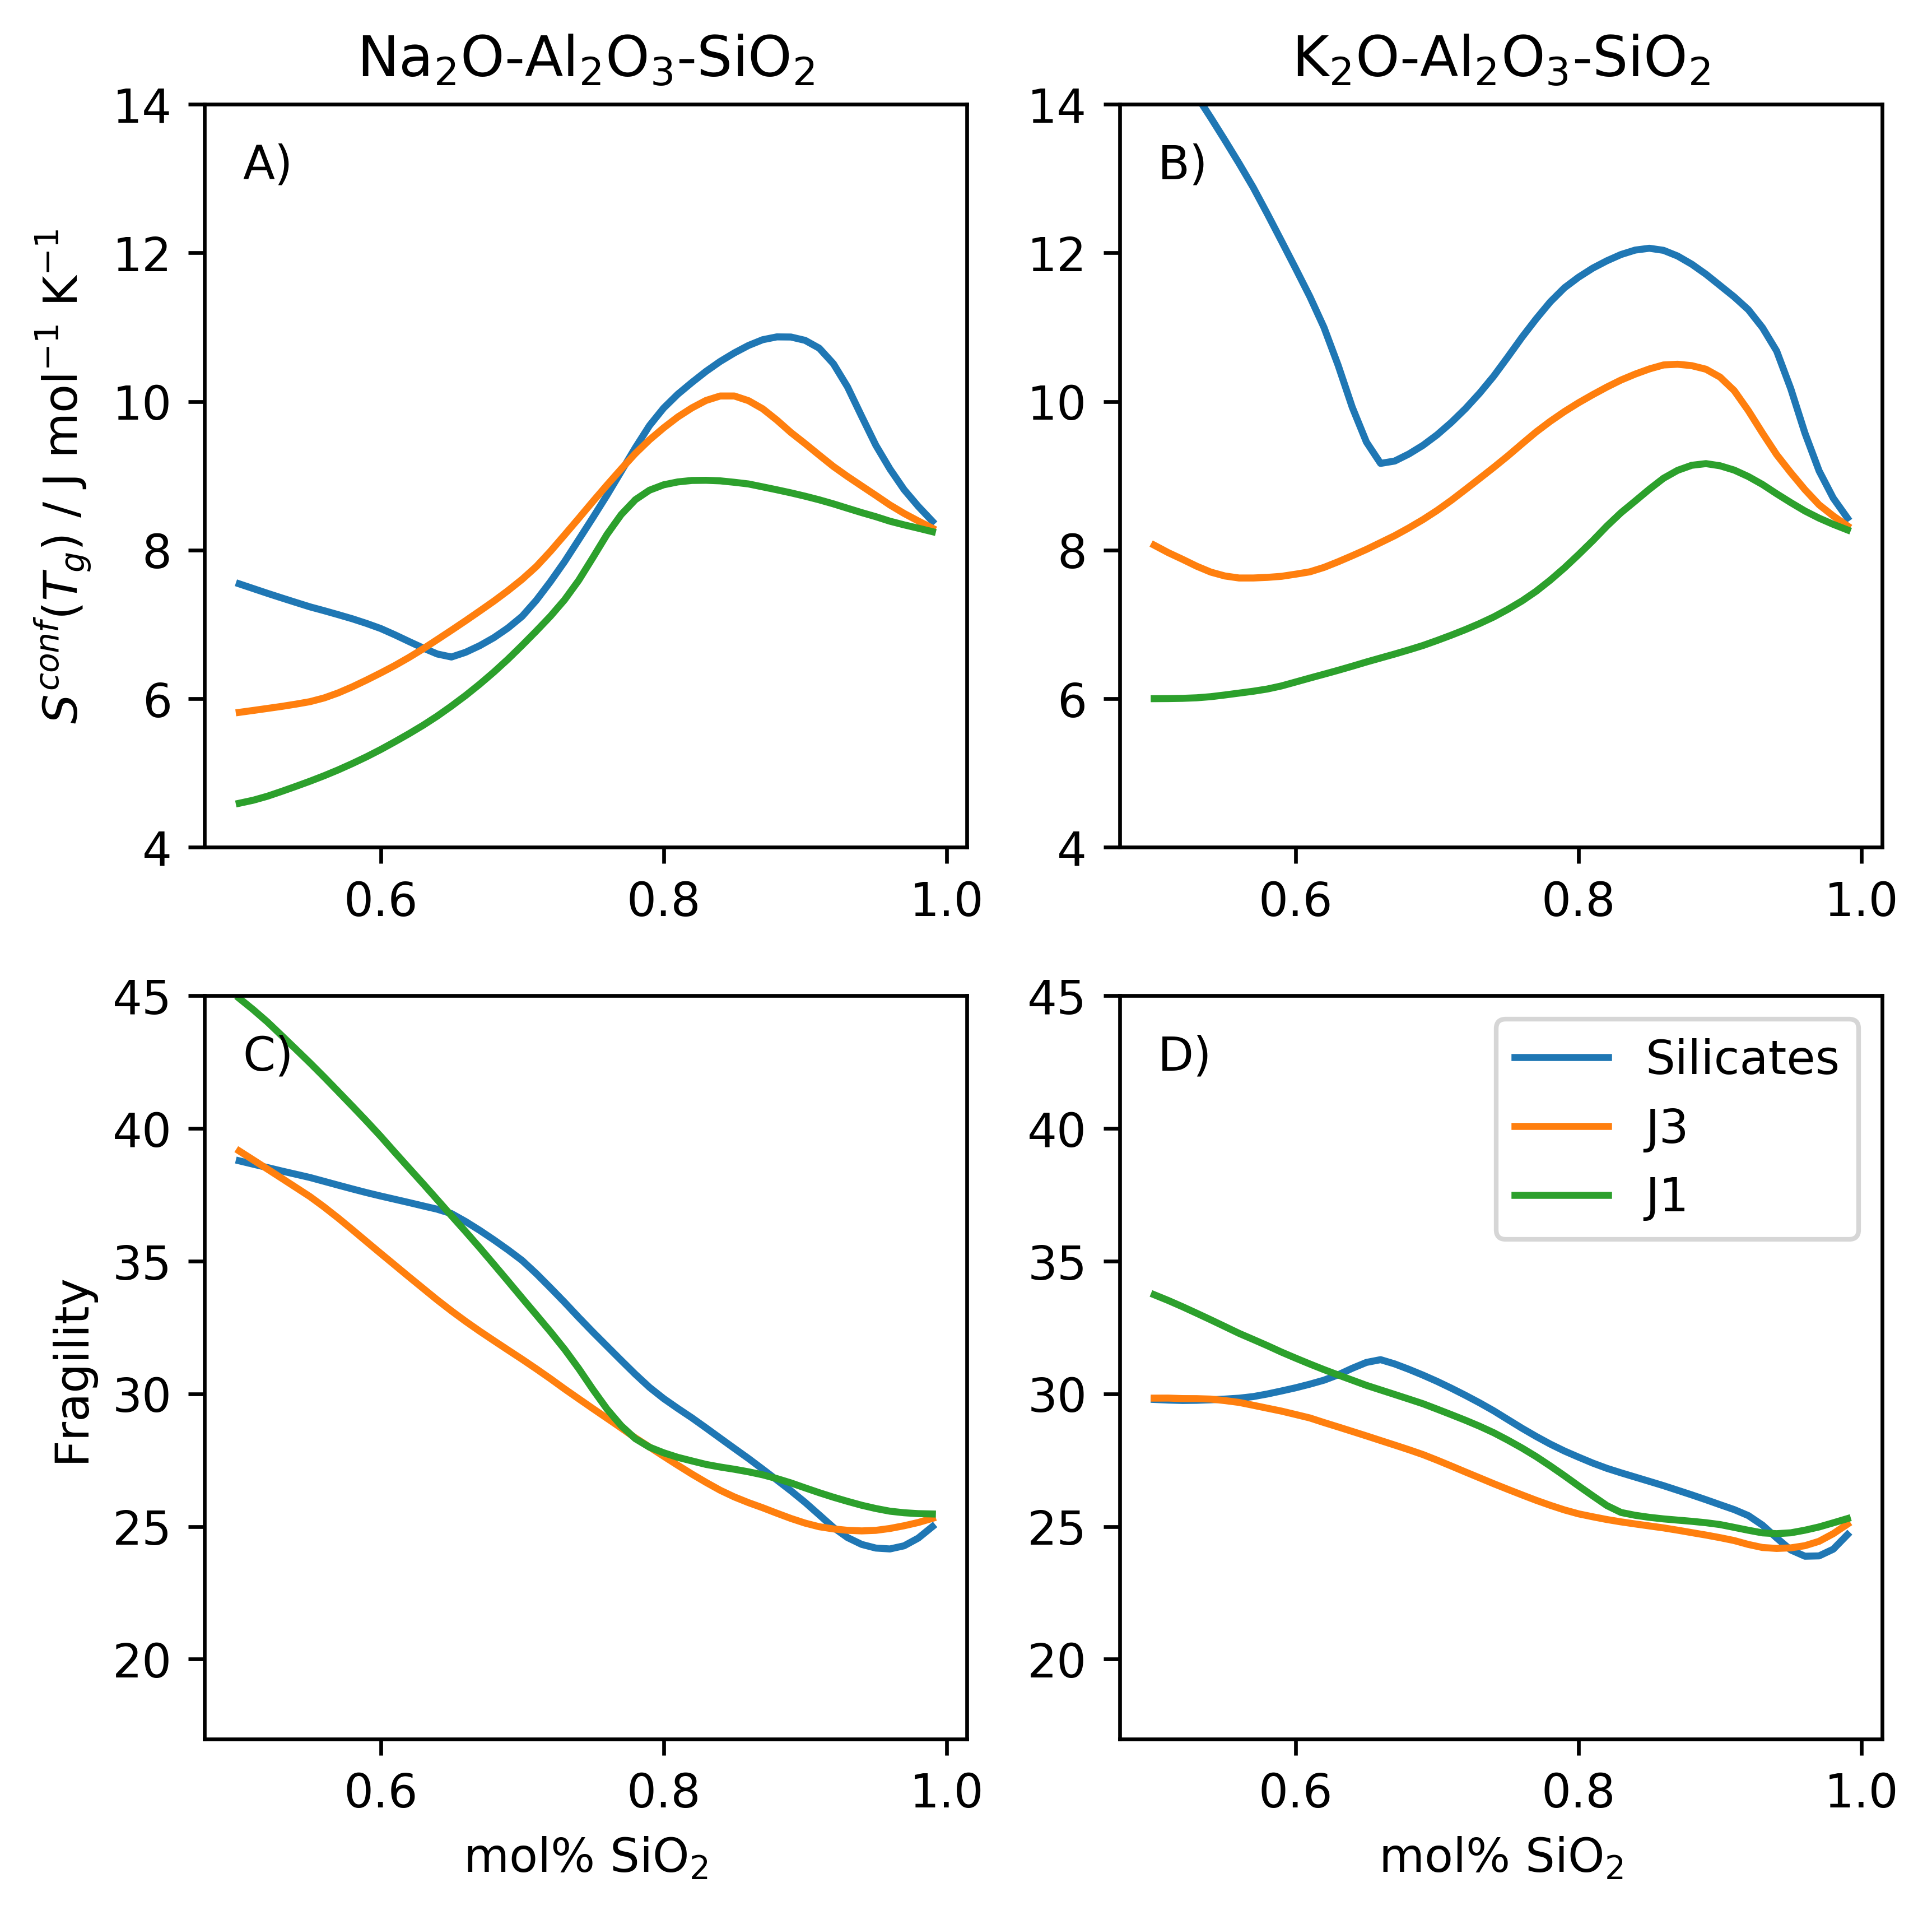

In [63]:
sio2 = np.arange(0.5,1.,0.01)

# order => sio2 al2o3 na2o k2o
X_visu_NAS_sili = np.vstack([sio2,np.zeros(len(sio2)),1.0-sio2,np.zeros(len(sio2))]).T
X_visu_NAS_J3 = np.vstack([sio2,(1.0-sio2)*1.0/3.0, (1.0-sio2)*2.0/3.0,np.zeros(len(sio2))]).T
X_visu_NAS_J1 = np.vstack([sio2,(1.0-sio2)*0.5, (1.0-sio2)*0.5,np.zeros(len(sio2))]).T

X_visu_KAS_sili = np.vstack([sio2,np.zeros(len(sio2)),np.zeros(len(sio2)),1.0-sio2]).T
X_visu_KAS_J3 = np.vstack([sio2,(1.0-sio2)*1.0/3.0,np.zeros(len(sio2)), (1.0-sio2)*2.0/3.0]).T
X_visu_KAS_J1 = np.vstack([sio2,(1.0-sio2)*0.5,np.zeros(len(sio2)), (1.0-sio2)*0.5]).T

Sctg_NAS_sili = neuralmodel.predict("sctg",X_visu_NAS_sili).mean(axis=1)
Sctg_NAS_J3 = neuralmodel.predict("sctg",X_visu_NAS_J3).mean(axis=1)
Sctg_NAS_J1 = neuralmodel.predict("sctg",X_visu_NAS_J1).mean(axis=1)

Sctg_KAS_sili = neuralmodel.predict("sctg",X_visu_KAS_sili).mean(axis=1)
Sctg_KAS_J3 = neuralmodel.predict("sctg",X_visu_KAS_J3).mean(axis=1)
Sctg_KAS_J1 = neuralmodel.predict("sctg",X_visu_KAS_J1).mean(axis=1)

tg_NAS_sili = neuralmodel.predict("tg",X_visu_NAS_sili).mean(axis=1)
tg_NAS_J3 = neuralmodel.predict("tg",X_visu_NAS_J3).mean(axis=1)
tg_NAS_J1 = neuralmodel.predict("tg",X_visu_NAS_J1).mean(axis=1)

tg_KAS_sili = neuralmodel.predict("tg",X_visu_KAS_sili).mean(axis=1)
tg_KAS_J3 = neuralmodel.predict("tg",X_visu_KAS_J3).mean(axis=1)
tg_KAS_J1 = neuralmodel.predict("tg",X_visu_KAS_J1).mean(axis=1)

m_NAS_sili = neuralmodel.predict("fragility",X_visu_NAS_sili).mean(axis=1)
m_NAS_J3 = neuralmodel.predict("fragility",X_visu_NAS_J3).mean(axis=1)
m_NAS_J1 = neuralmodel.predict("fragility",X_visu_NAS_J1).mean(axis=1)

m_KAS_sili = neuralmodel.predict("fragility",X_visu_KAS_sili).mean(axis=1)
m_KAS_J3 = neuralmodel.predict("fragility",X_visu_KAS_J3).mean(axis=1)
m_KAS_J1 = neuralmodel.predict("fragility",X_visu_KAS_J1).mean(axis=1)

print("Checking shape...")
print(X_visu_KAS_J1.shape)

plt.figure(figsize=(6.44,6.44), dpi=600)

plt.subplot(2,2,1) # NAS entropy

plt.plot(X_visu_NAS_sili[:,0],Sctg_NAS_sili,color="C0",label="Silicates")
plt.plot(X_visu_NAS_J3[:,0],Sctg_NAS_J3,color="C1",label="J3")
plt.plot(X_visu_NAS_J1[:,0],Sctg_NAS_J1,color="C2",label="J1")

plt.title(r"Na$_2$O-Al$_2$O$_3$-SiO$_2$")
plt.ylabel("$S^{conf}(T_g)$ / J mol$^{-1}$ K$^{-1}$")
plt.annotate("A)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")
plt.ylim(4,14)

plt.subplot(2,2,2) # KAS entropy

plt.plot(X_visu_KAS_sili[:,0],Sctg_KAS_sili,color="C0",label="Silicates")
plt.plot(X_visu_KAS_J3[:,0],Sctg_KAS_J3,color="C1",label="J3")
plt.plot(X_visu_KAS_J1[:,0],Sctg_KAS_J1,color="C2",label="J1")

plt.title(r"K$_2$O-Al$_2$O$_3$-SiO$_2$")
plt.annotate("B)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")
plt.ylim(4,14)

plt.subplot(2,2,3) # NAS fragility

plt.plot(X_visu_NAS_sili[:,0],m_NAS_sili,color="C0",label="Silicates")
plt.plot(X_visu_NAS_J3[:,0],m_NAS_J3,color="C1",label="J3")
plt.plot(X_visu_NAS_J1[:,0],m_NAS_J1,color="C2",label="J1")

plt.xlabel("mol% SiO$_2$")
plt.ylabel("Fragility")
plt.annotate("C)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")
plt.ylim(17,45)

plt.subplot(2,2,4) # KAS fragility

plt.plot(X_visu_KAS_sili[:,0],m_KAS_sili,color="C0",label="Silicates")
plt.plot(X_visu_KAS_J3[:,0],m_KAS_J3,color="C1",label="J3")
plt.plot(X_visu_KAS_J1[:,0],m_KAS_J1,color="C2",label="J1")
plt.ylim(17,45)

plt.xlabel("mol% SiO$_2$")
plt.annotate("D)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.legend(loc="upper right")

# Raman figure

Median of the Relative Least Absolute Deviation on Train Raman dataset is 18.44%
Median of the Relative Least Absolute Deviation on Valid Raman dataset is 22.10%


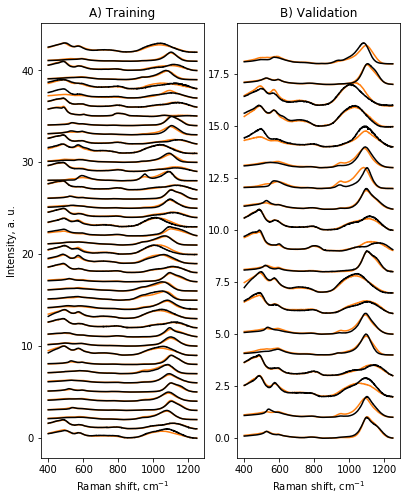

In [64]:
x_raman_shift = np.arange(400.,1250.,1.0) # our real x axis, for resampling

# Predictions for Raman spectra
raman_train_predictions = neuralmodel.predict("raman_pred",ds.x_raman_train).mean(axis=2)
raman_valid_predictions = neuralmodel.predict("raman_pred",ds.x_raman_valid).mean(axis=2)

plt.figure(figsize=(6.44,8))

plt.subplot(1,2,1)
plt.title("A) Training")
Raman_error_train = np.zeros(ds.x_raman_train.shape[0])
shift = 0.
for i in range(ds.x_raman_train.shape[0]):
    Raman_error_train[i] = np.mean(np.abs(raman_train_predictions[i,:]-ds.y_raman_train[i,:].detach().numpy())/raman_train_predictions[i,:])
    plt.plot(x_raman_shift,raman_train_predictions[i,:]+shift,color="C1")
    plt.plot(x_raman_shift,ds.y_raman_train[i,:].detach().numpy()+shift,"k-")
    shift += 1.
plt.xlabel("Raman shift, cm$^{-1}$")
plt.ylabel("Intensity, a. u.")

print("Median of the Relative Least Absolute Deviation on Train Raman dataset is {0:.2f}%".format(np.median(Raman_error_train)*100))

plt.subplot(1,2,2)
plt.title("B) Validation")
Raman_error_valid = np.zeros(ds.x_raman_valid.shape[0])
shift = 0.
for i in range(ds.x_raman_valid.shape[0]):
    Raman_error_valid[i] = np.mean(np.abs(raman_valid_predictions[i,:]-ds.y_raman_valid[i,:].detach().numpy())/raman_valid_predictions[i,:])
    plt.plot(x_raman_shift,raman_valid_predictions[i,:]+shift,color="C1")
    plt.plot(x_raman_shift,ds.y_raman_valid[i,:].detach().numpy()+shift,"k-")
    shift += 1.

plt.xlabel("Raman shift, cm$^{-1}$")
plt.savefig("./figures/SupplementaryFigure6_Raman_preds.pdf")

print("Median of the Relative Least Absolute Deviation on Valid Raman dataset is {0:.2f}%".format(np.median(Raman_error_valid)*100))
#idx_min_train = np.where(sp[:,1] == np.min(sp[(800<= sp[:,0])&(sp[:,0]<=1000),1]))[0][0]

#
# Calculating the R_Raman
#

Rr_train = np.trapz(ds.y_raman_train.detach().numpy()[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(ds.y_raman_train.detach().numpy()[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)
Rr_valid = np.trapz(ds.y_raman_valid.detach().numpy()[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(ds.y_raman_valid.detach().numpy()[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)

Rr_train_pred = np.trapz(raman_train_predictions[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(raman_train_predictions[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)
Rr_valid_pred = np.trapz(raman_valid_predictions[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(raman_valid_predictions[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)

#
# Some predictions for later
# 

visu_KAS_Raman_sili = neuralmodel.predict("raman_pred",X_visu_KAS_sili).mean(axis=2)
visu_KAS_Raman_J3 = neuralmodel.predict("raman_pred",X_visu_KAS_J3).mean(axis=2)
visu_KAS_Raman_J1 = neuralmodel.predict("raman_pred",X_visu_KAS_J1).mean(axis=2)

visu_NAS_Raman_sili = neuralmodel.predict("raman_pred",X_visu_NAS_sili).mean(axis=2)
visu_NAS_Raman_J3 = neuralmodel.predict("raman_pred",X_visu_NAS_J3).mean(axis=2)
visu_NAS_Raman_J1 = neuralmodel.predict("raman_pred",X_visu_NAS_J1).mean(axis=2)

Rr_KAS_sili = np.trapz(visu_KAS_Raman_sili[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_KAS_Raman_sili[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)
Rr_KAS_J3 = np.trapz(visu_KAS_Raman_J3[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_KAS_Raman_J3[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)
Rr_KAS_J1 = np.trapz(visu_KAS_Raman_J1[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_KAS_Raman_J1[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)

Rr_NAS_sili = np.trapz(visu_NAS_Raman_sili[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_NAS_Raman_sili[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)
Rr_NAS_J3 = np.trapz(visu_NAS_Raman_J3[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_NAS_Raman_J3[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)
Rr_NAS_J1 = np.trapz(visu_NAS_Raman_J1[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_NAS_Raman_J1[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)


# Supplementary Figure : Comparison between known values and predictions for other parameters (Tg, entropy...)

Tg test RMSE: 16.0
ScTg test RMSE: 0.8
density test RMSE: 0.009
Refractive index test RMSE: 0.0047


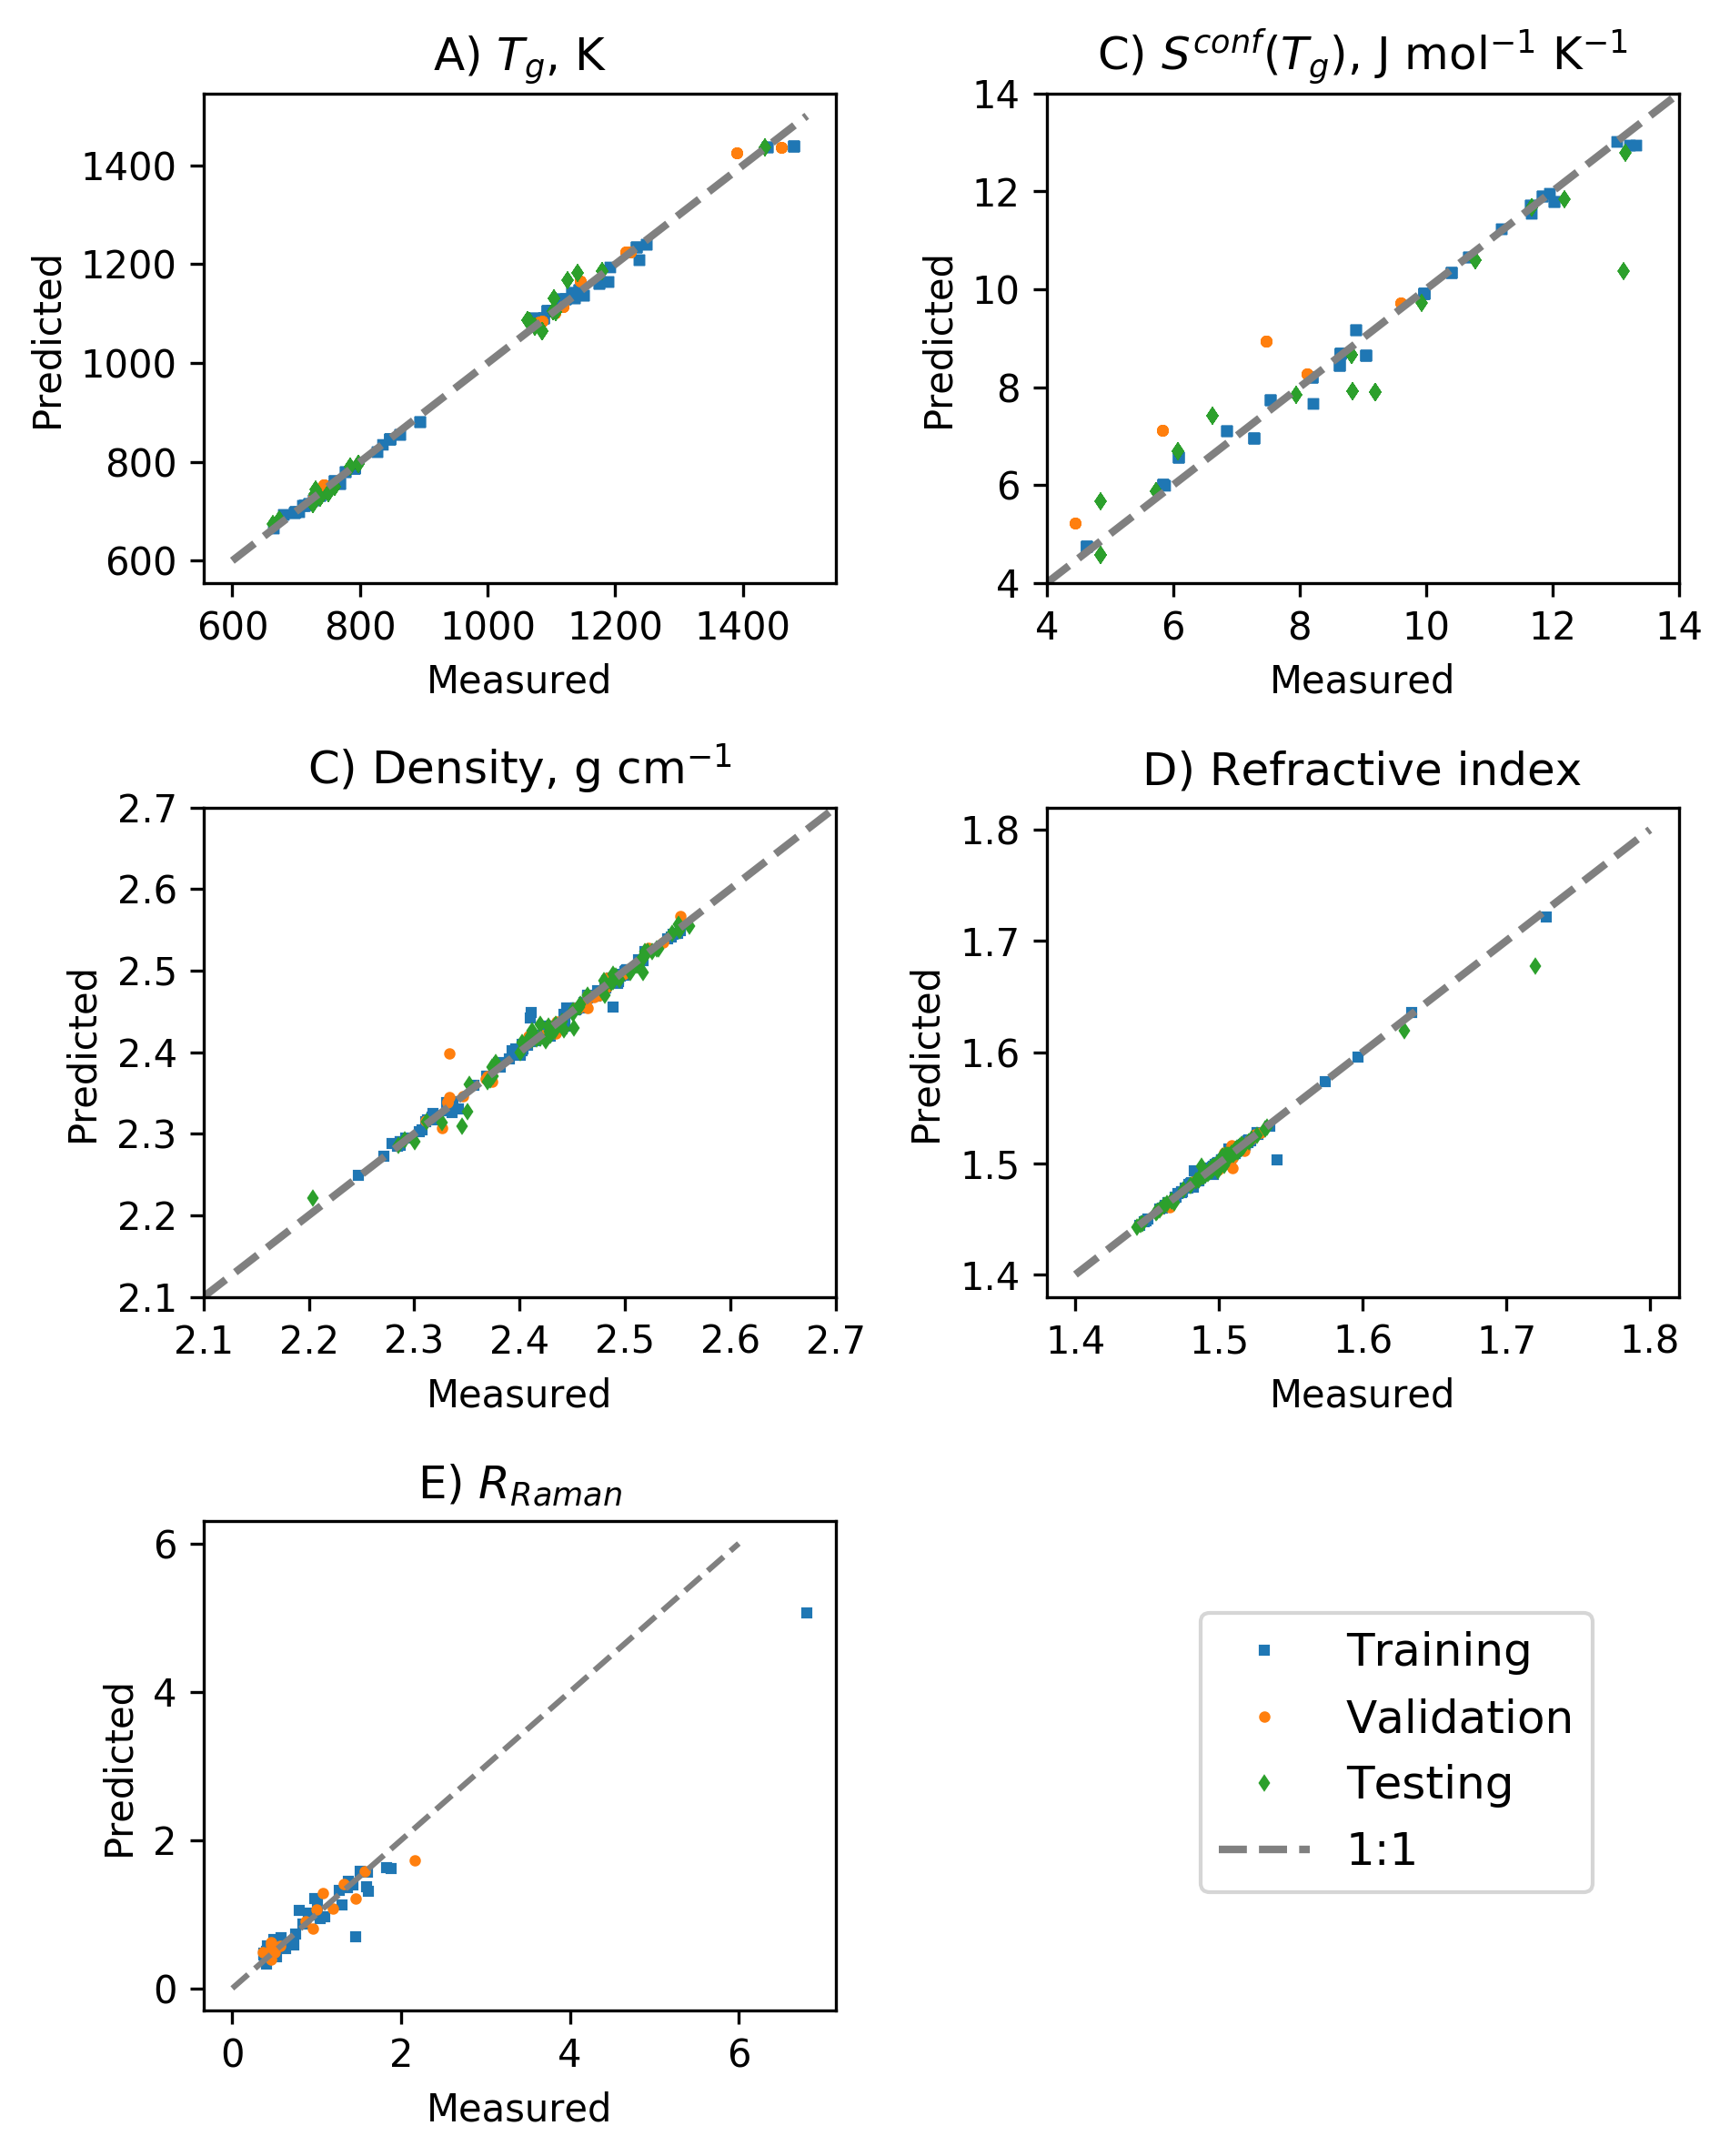

In [83]:
plt.figure(figsize=(6.44,8),dpi=300)

#
# Glass transition temperature
#
tx1 = plt.subplot(3,2,1)
tx1.plot(ds.y_tg_train.cpu().detach().numpy(),neuralmodel.predict("tg",ds.x_tg_train).mean(axis=1),
         "s",linestyle="none",color="C0",markersize=2,label="Train")
tx1.plot(ds.y_tg_valid.cpu().detach().numpy(),neuralmodel.predict("tg",ds.x_tg_valid).mean(axis=1),
         "o",color="C1",markersize=2,label="Valid")
tx1.plot(ds.y_tg_test.cpu().detach().numpy(),neuralmodel.predict("tg",ds.x_tg_test).mean(axis=1),
         "d",color="C2",markersize=2,label="Test")
RMSE_test_Tg = np.sqrt(mean_squared_error(ds.y_tg_test.cpu().detach().numpy(),neuralmodel.predict("tg",ds.x_tg_test).mean(axis=1))) 
print("Tg test RMSE: {0:.1f}".format(RMSE_test_Tg))

plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"A) $T_g$, K")

plt.plot([600,1500],[600,1500],"--",color="grey",linewidth=2,label="1:1")

#plt.legend(loc="upper left")

#
# Configurational entropy
#

tx2 = plt.subplot(3,2,2)
tx2.plot(ds.y_entro_train.cpu().detach().numpy(),neuralmodel.predict("sctg",ds.x_entro_train).mean(axis=1),
         "s",color="C0",markersize=2,label="Train")
tx2.plot(ds.y_entro_valid.cpu().detach().numpy(),neuralmodel.predict("sctg",ds.x_entro_valid).mean(axis=1),
         "o",color="C1",markersize=2,label="Valid")
tx2.plot(ds.y_entro_test.cpu().detach().numpy(),neuralmodel.predict("sctg",ds.x_entro_test).mean(axis=1),
         "d",color="C2",markersize=2,label="Test")
RMSE_test_ScTg = np.sqrt(mean_squared_error(ds.y_entro_test.cpu().detach().numpy(),neuralmodel.predict("sctg",ds.x_entro_test).mean(axis=1))) 
print("ScTg test RMSE: {0:.1f}".format(RMSE_test_ScTg))

plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"C) $S^{conf}(T_g)$, J mol$^{-1}$ K$^{-1}$")
plt.xlim(4,14)
plt.ylim(4,14)
plt.plot([4,14],[4,14],"--",color="grey",linewidth=2,label="1:1")

#
# Density
#

tx3=plt.subplot(3,2,3)
tx3.plot(ds.y_density_train.cpu().detach().numpy(),neuralmodel.predict("density",ds.x_density_train).mean(axis=1),
         "s",color="C0",markersize=2,label="Train")
tx3.plot(ds.y_density_valid.cpu().detach().numpy(),neuralmodel.predict("density",ds.x_density_valid).mean(axis=1),
         "o",color="C1",markersize=2,label="Valid")
tx3.plot(ds.y_density_test.cpu().detach().numpy(),neuralmodel.predict("density",ds.x_density_test).mean(axis=1),
         "d",color="C2",markersize=2,label="Test")
RMSE_test_d = np.sqrt(mean_squared_error(ds.y_density_test.cpu().detach().numpy(),neuralmodel.predict("density",ds.x_density_test).mean(axis=1))) 
print("density test RMSE: {0:.3f}".format(RMSE_test_d))


plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"C) Density, g cm$^{-1}$")

plt.plot([2.1,2.7],[2.1,2.7],"--",color="grey",linewidth=2,label="1:1")

plt.xlim(2.1,2.7)
plt.ylim(2.1,2.7)
plt.xticks([2.1,2.2,2.3,2.4,2.5,2.6,2.7])
plt.yticks([2.1,2.2,2.3,2.4,2.5,2.6,2.7])

#
# Refractive index
#

tx4 = plt.subplot(3,2,4)

tx4.plot(ds.y_ri_train.cpu().detach().numpy(),neuralmodel.predict("sellmeier",ds.x_ri_train, lbd=ds.lbd_ri_train).mean(axis=1),
         "s",color="C0",markersize=2,label="Training")
tx4.plot(ds.y_ri_valid.cpu().detach().numpy(),neuralmodel.predict("sellmeier",ds.x_ri_valid, lbd=ds.lbd_ri_valid).mean(axis=1),
         "o",color="C1",markersize=2,label="Validation")
tx4.plot(ds.y_ri_test.cpu().detach().numpy(),neuralmodel.predict("sellmeier",ds.x_ri_test, lbd=ds.lbd_ri_test).mean(axis=1),
         "d",color="C2",markersize=2,label="Testing")
RMSE_test_ri = np.sqrt(mean_squared_error(ds.y_ri_test.cpu().detach().numpy(),neuralmodel.predict("sellmeier",ds.x_ri_test, lbd=ds.lbd_ri_test).mean(axis=1))) 
print("Refractive index test RMSE: {0:.4f}".format(RMSE_test_ri))

plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"D) Refractive index")

plt.plot([1.4,1.8],[1.4,1.8],"--",color="grey",linewidth=2,label="1:1")
plt.xticks(np.arange(1.4,1.8,0.1))
plt.yticks(np.arange(1.4,1.8,0.1))

#
# Raman predictions : ratio of low to high frequency peaks
#

tx5 = plt.subplot(3,2,5)

plt.plot(Rr_train,Rr_train_pred,"s",color="C0",alpha=1,markersize=2,label="Training")
plt.plot(Rr_valid,Rr_valid_pred,"o",color="C1",alpha=1,markersize=2,label="Validation")
plt.plot([0,6],[0,6],"--",color="grey")

plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"E) $R_{Raman}$")

plt.tight_layout()

tx4.legend(fontsize=12, bbox_to_anchor=(0.9,-0.6))

plt.savefig("./figures/SupplementaryFigure-TgSdn.png")

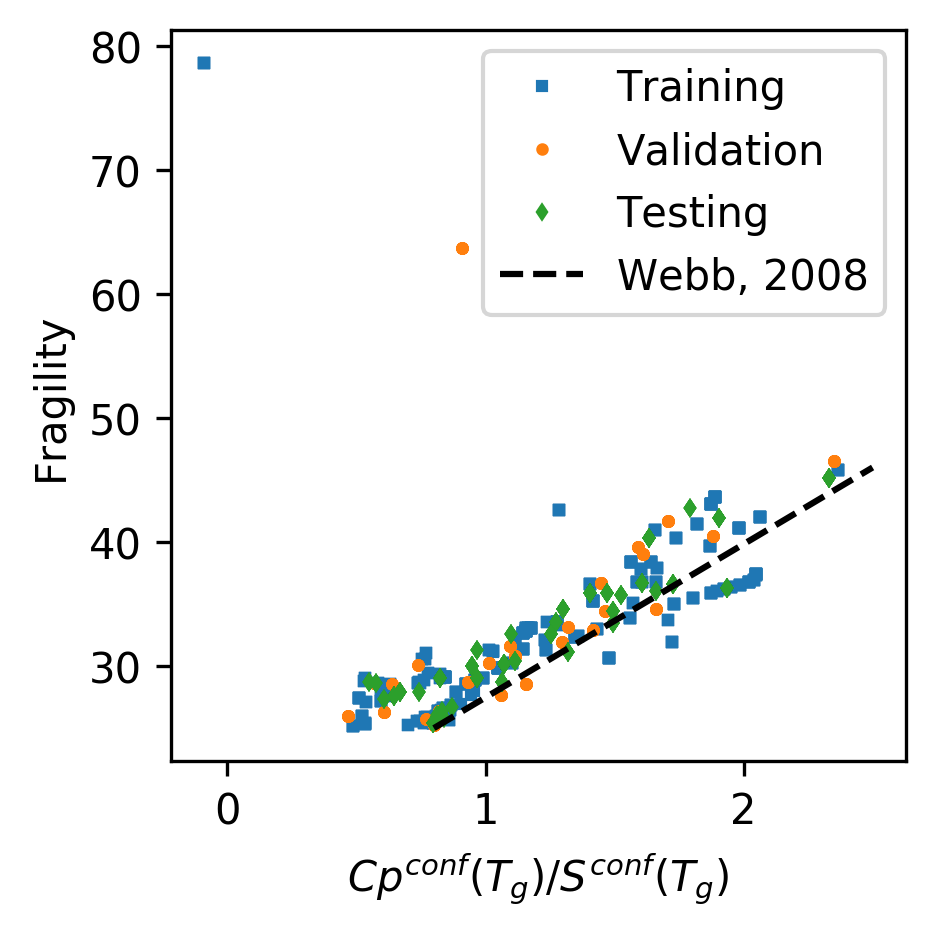

In [13]:
plt.figure(figsize=(3.22,3.22),dpi=300)
# Train

Cpconf = neuralmodel.predict("ap_calc",ds.x_visco_train).mean(axis=1) + neuralmodel.predict("b_calc",ds.x_visco_train).mean(axis=1)* neuralmodel.predict("tg",ds.x_visco_train).mean(axis=1)
Cp_S = Cpconf/neuralmodel.predict("sctg",ds.x_visco_train).mean(axis=1)

plt.plot(Cp_S,neuralmodel.predict("fragility",ds.x_visco_train).mean(axis=1),
         "s",color="C0",markersize=2,label="Training")

# Valid
Cpconf = neuralmodel.predict("ap_calc",ds.x_visco_valid).mean(axis=1) + neuralmodel.predict("b_calc",ds.x_visco_valid).mean(axis=1)* neuralmodel.predict("tg",ds.x_visco_valid).mean(axis=1)
Cp_S = Cpconf/neuralmodel.predict("sctg",ds.x_visco_valid).mean(axis=1)

plt.plot(Cp_S,neuralmodel.predict("fragility",ds.x_visco_valid).mean(axis=1),
         "o",color="C1",markersize=2,label="Validation")

# Test
Cpconf = neuralmodel.predict("ap_calc",ds.x_visco_test).mean(axis=1) + neuralmodel.predict("b_calc",ds.x_visco_test).mean(axis=1)* neuralmodel.predict("tg",ds.x_visco_test).mean(axis=1)
Cp_S = Cpconf/neuralmodel.predict("sctg",ds.x_visco_test).mean(axis=1)

plt.plot(Cp_S,neuralmodel.predict("fragility",ds.x_visco_test).mean(axis=1),
         "d",color="C2",markersize=2,label="Testing")

plt.plot([0.8, 2.5],[25., 46],"k--",label="Webb, 2008")

plt.xlabel(r"$Cp^{conf}(T_g)/S^{conf}(T_g)$")
plt.ylabel("Fragility")

plt.legend()
plt.tight_layout()
plt.savefig("./figures/SupplementaryFigure_mVSCpS.png")

# Visualize correlations

In [150]:
nb_samples = 10000
sio2_gen = np.random.random_sample(nb_samples)*0.5 + 0.5

reminder = 1.0 - sio2_gen

R_MAl = np.random.random_sample(nb_samples)*(1.0-0.4) + 0.4 # ratio of alkalis to Al

R_XK = np.random.random_sample(nb_samples) # ratio K/(K+Na)

al2o3_gen = (1.0 - R_MAl)*reminder

reminder = 1 - sio2_gen - al2o3_gen

na2o_gen = reminder*(1.0-R_XK)
k2o_gen = 1 - sio2_gen - al2o3_gen - na2o_gen

X_gen = pd.DataFrame()
X_gen["sio2"] = sio2_gen
X_gen["al2o3"] = al2o3_gen
X_gen["na2o"] = na2o_gen
X_gen["k2o"] = k2o_gen
M_glass = sio2_gen*60.08 + al2o3_gen*101.96 + na2o_gen*61.9789 + k2o_gen*94.2
X_rec = X_gen.copy()
X_gen = torch.Tensor(X_gen.values).to(device)

Raman_gen = neuralmodel.predict("raman_pred",X_gen).mean(axis=2)

Rr_gen = np.trapz(Raman_gen[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(Raman_gen[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)

samples = np.concatenate((neuralmodel.predict("ae",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("a_am",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("a_cg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("be",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("sctg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("be",X_gen).mean(axis=1).reshape(-1,1)/neuralmodel.predict("sctg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("b_cg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("b_tvf",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("to_cg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("c_cg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("c_tvf",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("fragility",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("density",X_gen).mean(axis=1).reshape(-1,1),
                          M_glass.reshape(-1,1)/neuralmodel.predict("density",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("tg",X_gen).mean(axis=1).reshape(-1,1),
                          neuralmodel.predict("sellmeier",X_gen,lbd=589.0*np.ones((len(X_gen),1))).mean(axis=1).reshape(-1,1),
                          Rr_gen.reshape(-1,1)
                         ),axis=1)

labels = [r"$A_e$", r"$A_{AM}$", r"$A_{CG}$", 
          r"$B_e$", r"$S^{conf}(T_g)$", r"$B_e/S^{conf}(T_g)$", 
          r"$B_{CG}$", r"$B_{TVF}$", r"$T_o$", r"$C_{CG}$", r"$C_{TVF}$", 
          r"m", r"d", r"$V_m$",r"$T_g$",r"$n_{589}$", r"R$_{Raman}$"]

samples_2 = np.concatenate((neuralmodel.predict("sellmeier",X_gen,lbd=589.0*np.ones((len(X_gen),1))).mean(axis=1).reshape(-1,1),
                            neuralmodel.predict("be",X_gen).mean(axis=1).reshape(-1,1)/neuralmodel.predict("sctg",X_gen).mean(axis=1).reshape(-1,1),
                            neuralmodel.predict("b_cg",X_gen).mean(axis=1).reshape(-1,1)/neuralmodel.predict("c_cg",X_gen).mean(axis=1).reshape(-1,1),
                            neuralmodel.predict("tg",X_gen).mean(axis=1).reshape(-1,1),
                            Rr_gen.reshape(-1,1)
                           ),axis=1)

labels_2 = [r"$n_{589}$", r"$B_e/S^{conf}(T_g)$", r"$B_{CG}$", r"$T_g$", r"R$_{Raman}$"]

# General correlation plot : all predicted variables

<Figure size 1080x1080 with 0 Axes>

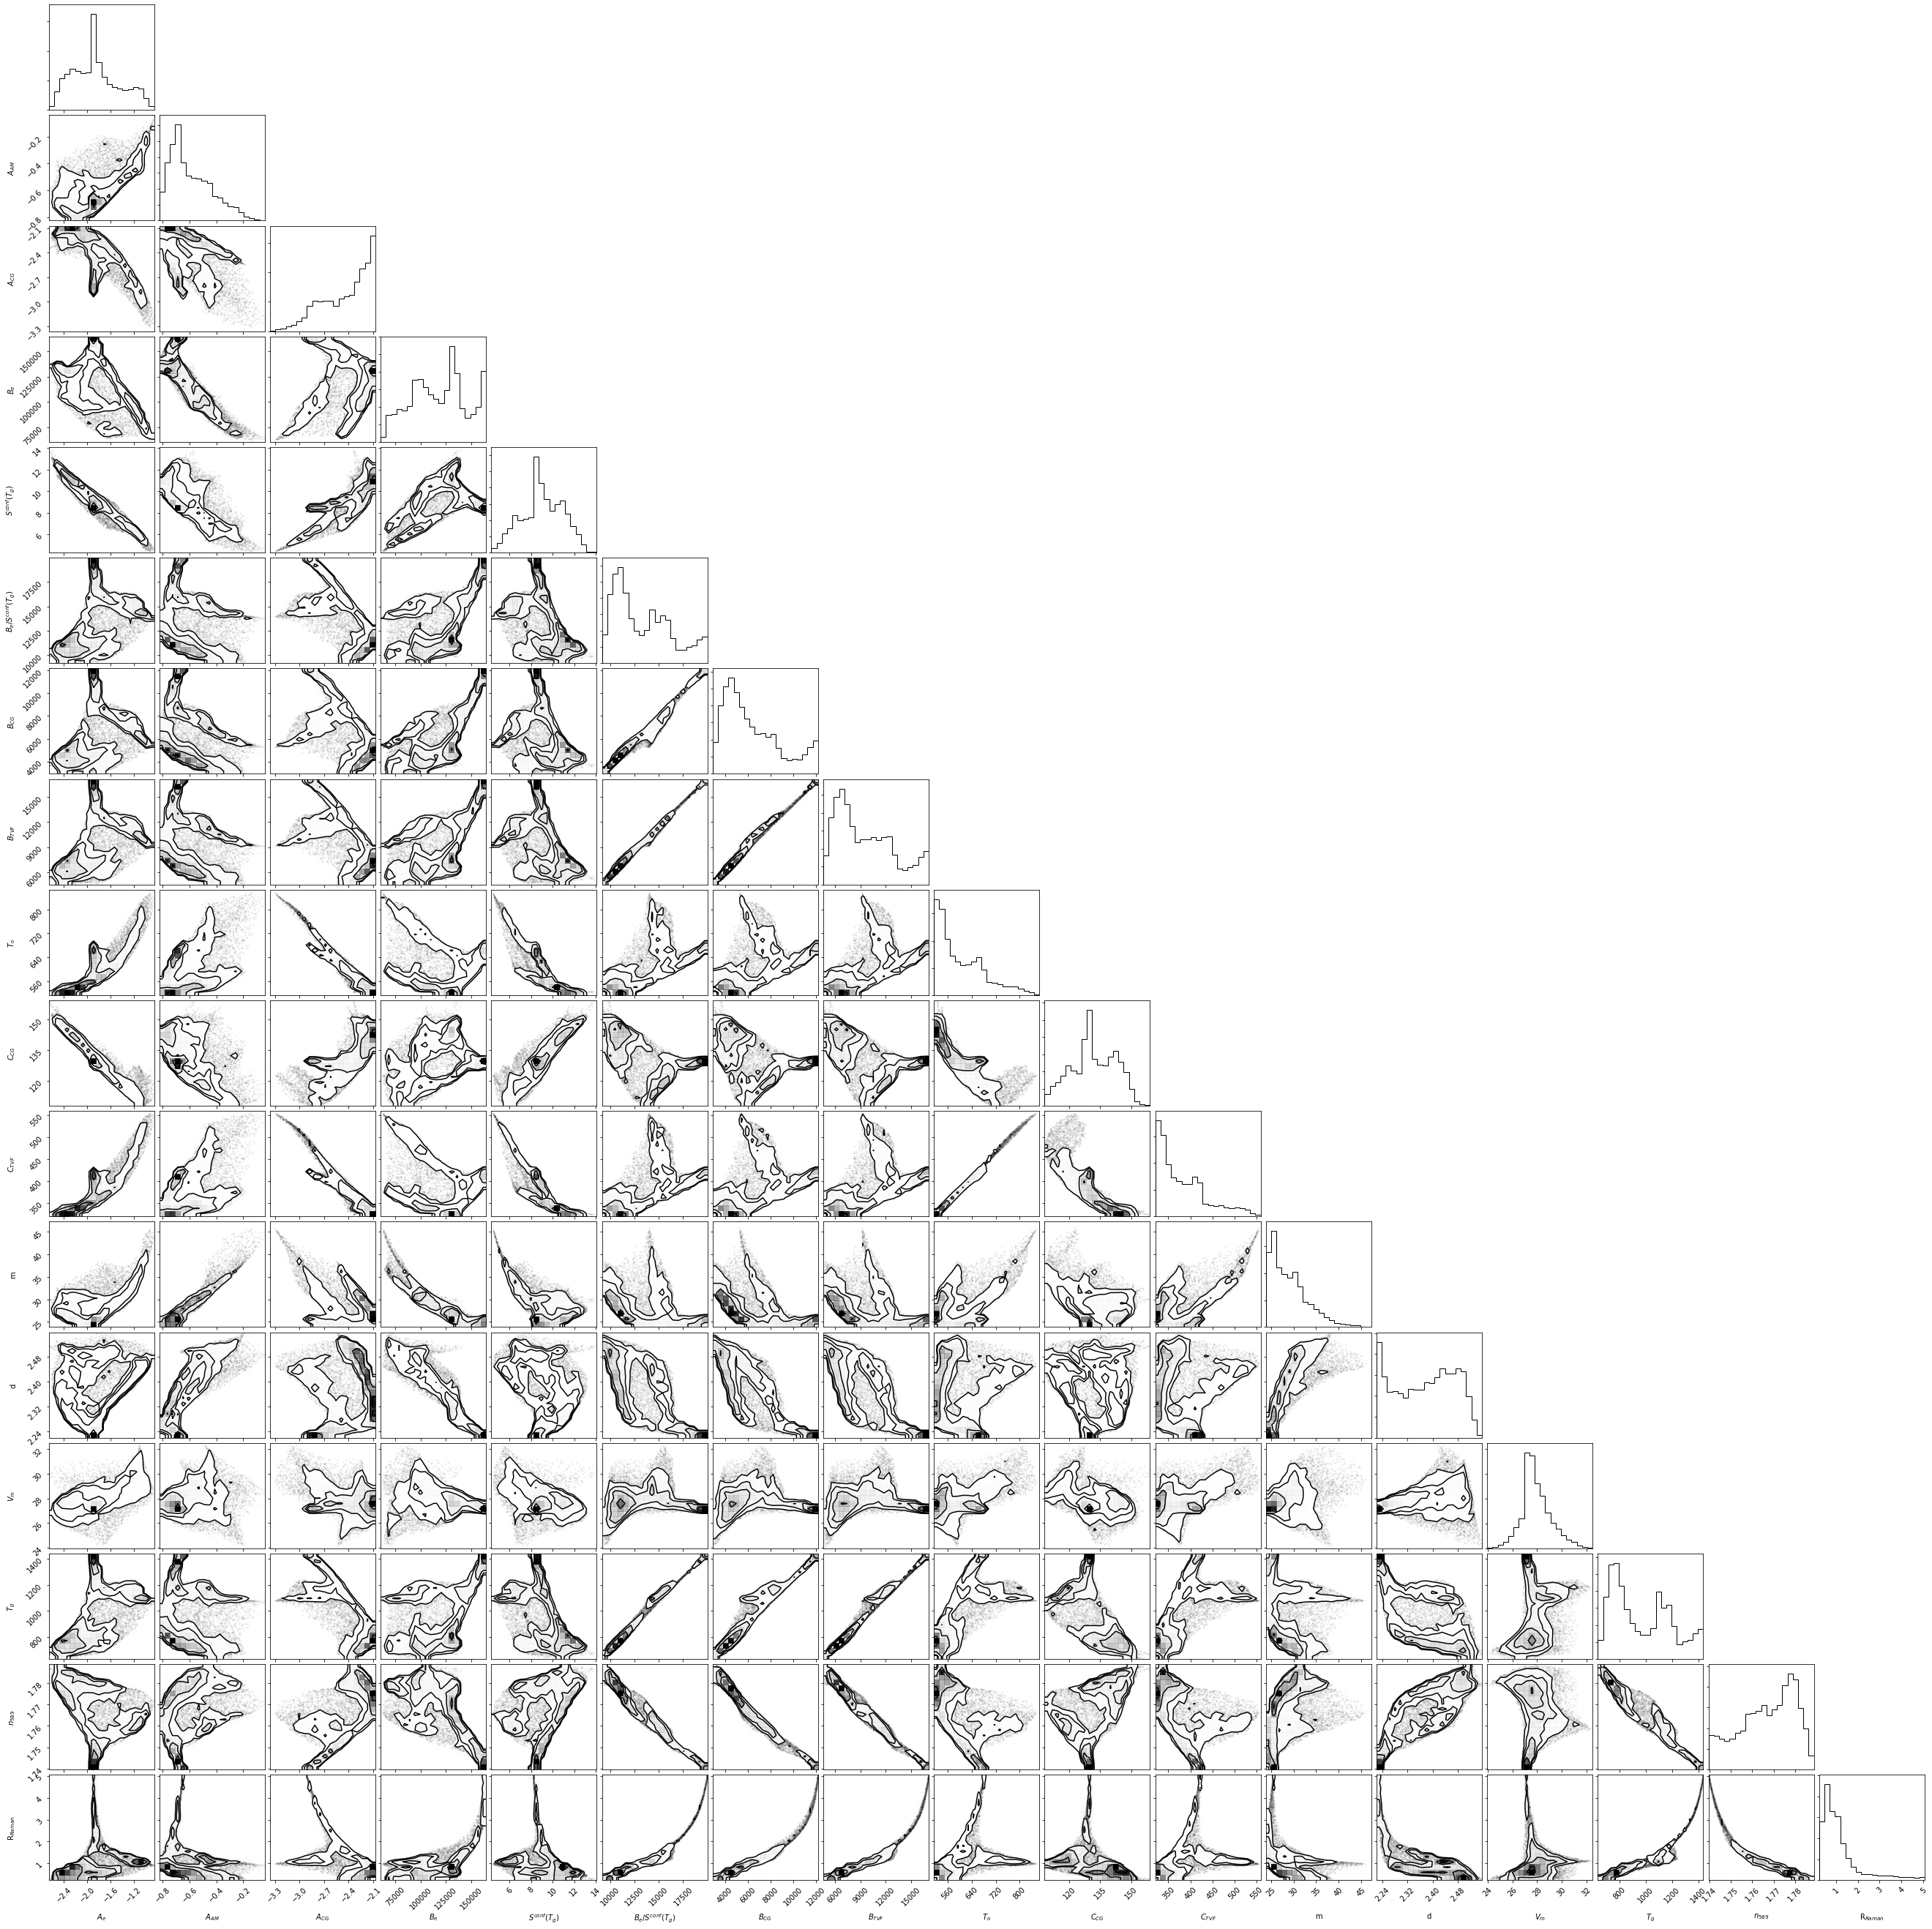

In [151]:
plt.figure(figsize=(15,15))
corner.corner(samples, labels=labels)

plt.savefig("./figures/Correlations.pdf")


Here we test Spearman correlations between variables, allows to see unlinear correlated features.

In [153]:
df_samples = pd.DataFrame(data= samples, columns=labels)
sp_corr = df_samples.corr(method="spearman")
# 'RdBu_r' & 'BrBG' are other good diverging colormaps
sp_corr.style.background_gradient(cmap='coolwarm')


# Specific correlation plots : specific variables

In [130]:
df_samples_2 = pd.DataFrame(data= samples_2, columns=labels_2)
sp_corr_2 = df_samples_2.corr(method="spearman")
# 'RdBu_r' & 'BrBG' are other good diverging colormaps
sp_corr_2.style.background_gradient(cmap='coolwarm')


From the above figure, we notice that several separated variables are actually well linearly correlated, like glass refractive index, glass transition temperature, $B_{CG}$ and  $B_e/S^{conf}(T_g)$.

It thus seem that the Free volume theory and the Adam and Gibbs theory succeed to capture the underlying reality behind glass transition temperature, glass structure, and hindrance of the atomic mobility.

However, R$_{Raman}$ is not linearly correlated to all those variables, suggesting that Raman spectroscpuy misses (is blind to) something there.

**I like this figure... what it tells is very important, it shows the ground links between measurable quantities (glass refractive index, Tg) and thermodynamic/dynamic model parameters.**

**[] should we add it as figure 4 ?**

**[] should we add coloring as previously done in figure 5 ?**

<Figure size 1200x800 with 0 Axes>

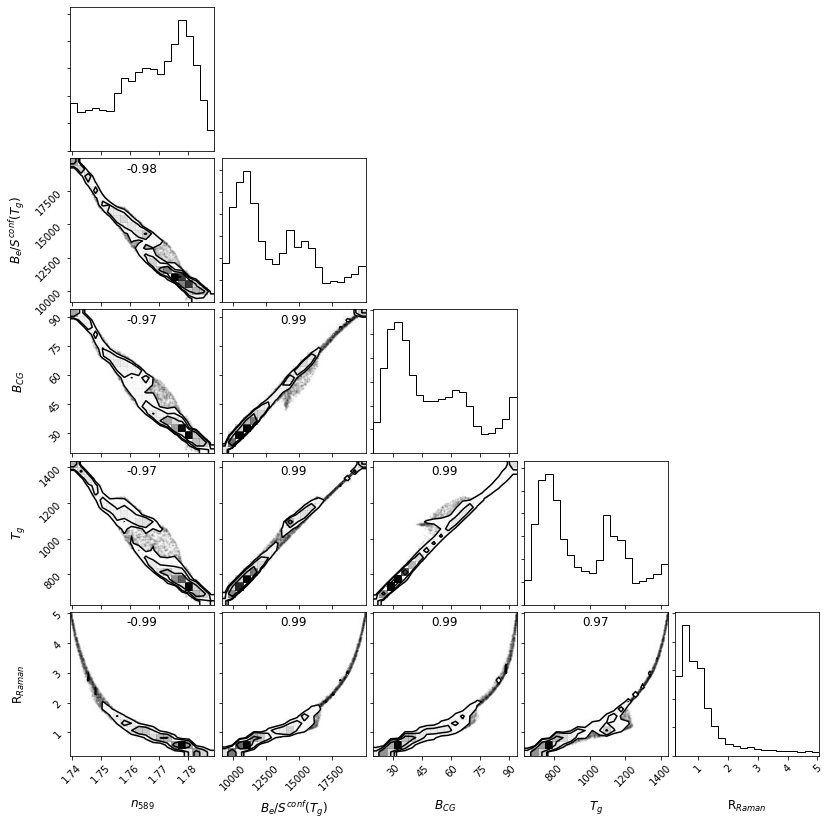

In [131]:
plt.figure(dpi=200)

label_kwargs = {"fontsize" : 12}

fig = corner.corner(samples_2, labels=labels_2, label_kwargs=label_kwargs)


# how many variables ?
ndim = samples_2.shape[1]

# Extract the axes
axes = np.array(fig.axes).reshape((ndim, ndim))

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        # add annotation with spearman correlation coefficient
        ax = axes[yi, xi]
        #ax.annotate("{}, {}".format(yi,xi),xy=(0.5,0.9),xycoords="axes fraction", ha='center')
        ax.annotate("{:.2f}".format(sp_corr_2.values[yi,xi]),xy=(0.5,0.9),xycoords="axes fraction", ha='center',fontsize=12)

# Figure XX: absence of direct link between network topology and parameters that embed entropic information.

Entropy is not only due to the network topology (the geometry of the Si-Al-O polyhedral network) but is also affected by mixing effects, e.g. between Al and Si as well as Na and K.

Therefore, any parameter that embeds entropic information is expected to vary in a complex way with $R_{Raman}$. 

This is what we observed here. Melt fragility (proportional to the ratio of entropy to heat capacity), configurational glass entropy, or $C_{CG}$ (critical free volume that should relate to the intrisic entropy) all vary in a complex way contary to other parameters that nearly directly depends on network topology (see last figure).

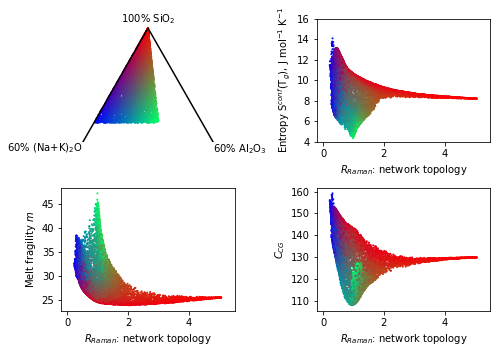

In [155]:
def CLR(input_array):
    """Transform chemical composition in colors
    
    Inputs
    ------
    input_array: n*4 array
        4 chemical inputs with sio2, al2o3, k2o and na2o in 4 columns, n samples in rows
        
    Returns
    -------
    out: n*3 array
        RGB colors
    """
    XXX = input_array.copy()
    XXX[:,2] = XXX[:,2]+XXX[:,3] # adding alkalis
    out = np.delete(XXX,3,1) # remove 4th row
    # min max scaling to have colors in the full RGB scale
    out[:,0] = (out[:,0]-out[:,0].min())/(out[:,0].max()-out[:,0].min())
    out[:,1] = (out[:,1]-out[:,1].min())/(out[:,1].max()-out[:,1].min())
    out[:,2] = (out[:,2]-out[:,2].min())/(out[:,2].max()-out[:,2].min())
    return out

X_rec_forcart = X_rec
X_rec_forcart["alkalis"] = X_rec.na2o+X_rec.k2o
cart_rec = bary2cart(X_rec_forcart.loc[:,["alkalis","sio2","al2o3"]].values, corners=np.array([[0,0],[1,1],[2,0]]))

plt.figure(figsize=(7,5))

####
#### TERNARY PLOT NAS
####
ax= plt.subplot(2,2,1)
#tc1 = plt.tricontourf(cart_gen[:,0], 
#                cart_gen[:,1], 
#                sctg_NAS, 
#                levels=20, cmap="RdBu_r")

ax.scatter(cart_rec[:,0],cart_rec[:,1],s=1,c=CLR(X_gen.detach().numpy()))
ax.plot([0,1,2,0],[0,1,0,0],"k-")

ax.set_xlim(0.2,1.8)
ax.set_ylim(0.4,1.05)

plt.annotate(r"100% SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"60% Al$_2$O$_3$", xy = (1.6,0.4),xycoords="data",ha="left",va="top")
plt.annotate(r"60% (Na+K)$_2$O", xy = (0.4,0.4),xycoords="data",ha="right",va="top")

ax.axis("off")


#ax.set_title("A) Na$_2$O-Al$_2$O$_3$-SiO$_2$ ternary", loc='center')


plt.subplot(2,2,2)
plt.scatter(Rr_gen.reshape(-1,1), neuralmodel.predict("sctg",X_gen).mean(axis=1), s=1,c=CLR(X_gen.detach().numpy()))

plt.xlim(-0.2,5.5)
plt.ylim(4,16)
plt.xlabel("$R_{Raman}$: network topology")
plt.ylabel(r"Entropy S$^{conf}$(T$_{g}$), J mol$^{-1}$ K$^{-1}$")

plt.subplot(2,2,3)
plt.scatter(Rr_gen.reshape(-1,1), neuralmodel.predict("fragility",X_gen).mean(axis=1), s=1,c=CLR(X_gen.detach().numpy()))

plt.xlim(-0.2,5.5)
#plt.ylim(18,47)
plt.xlabel("$R_{Raman}$: network topology")
plt.ylabel(r"Melt fragility $m$")

plt.subplot(2,2,4)
plt.scatter(Rr_gen.reshape(-1,1), neuralmodel.predict("c_cg",X_gen).mean(axis=1), s=1,c=CLR(X_gen.detach().numpy()))

plt.xlim(-0.2,5.5)
#plt.ylim(18,47)
plt.xlabel("$R_{Raman}$: network topology")
plt.ylabel(r"$C_{CG}$")

plt.tight_layout()

# Additional dummy plots for thinking

I noticed that B_TVF and B_CG as well as C_TVF and TO_CG are largely correlated...

Basically this tells us that the CG equation is an improvement of the TVF equation ? To and C_TVF are related to the Kauzman temperature... Something to dig there.

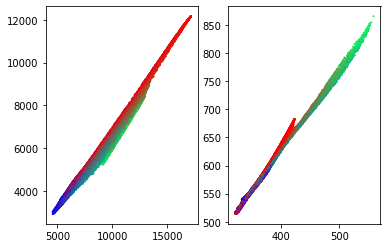

In [154]:
plt.subplot(1,2,1)
plt.scatter(neuralmodel.predict("b_tvf",X_gen).mean(axis=1),              
            neuralmodel.predict("b_cg",X_gen).mean(axis=1),
            s=1,c=CLR(X_gen.detach().numpy()))
plt.subplot(1,2,2)
plt.scatter(neuralmodel.predict("c_tvf",X_gen).mean(axis=1),              
            neuralmodel.predict("to_cg",X_gen).mean(axis=1),
            s=1,c=CLR(X_gen.detach().numpy()))


# For presentation

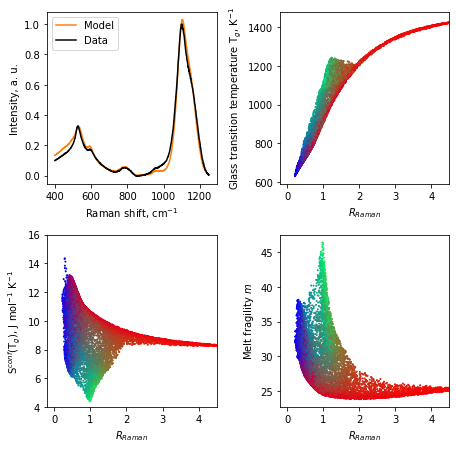

In [87]:
plt.figure(figsize=(6.44,6.44))

plt.subplot(2,2,1)

plt.plot(x_raman_shift,raman_valid_predictions[0,:],color="C1",label="Model")
plt.plot(x_raman_shift,ds.y_raman_valid[0,:].detach().numpy(),"k-",label="Data")


plt.xlabel("Raman shift, cm$^{-1}$")
plt.ylabel("Intensity, a. u.")

plt.legend(loc="best")

plt.subplot(2,2,2)
plt.scatter(Rr_gen.reshape(-1,1), neuralmodel.predict("tg",X_gen).mean(axis=1), s=1,c=CLR(X_gen.detach().numpy()))

plt.xlim(-0.2,4.5)
plt.xlabel("$R_{Raman}$")
plt.ylabel(r"Glass transition temperature T$_{g}$, K$^{-1}$")

plt.subplot(2,2,3)
plt.scatter(Rr_gen.reshape(-1,1), neuralmodel.predict("sctg",X_gen).mean(axis=1), s=1,c=CLR(X_gen.detach().numpy()))

plt.xlim(-0.2,4.5)
plt.ylim(4,16)
plt.xlabel("$R_{Raman}$")
plt.ylabel(r"S$^{conf}$(T$_{g}$), J mol$^{-1}$ K$^{-1}$")

plt.subplot(2,2,4)
plt.scatter(Rr_gen.reshape(-1,1), neuralmodel.predict("fragility",X_gen).mean(axis=1), s=1,c=CLR(X_gen.detach().numpy()))

plt.xlim(-0.2,4.5)
#plt.ylim(18,47)
plt.xlabel("$R_{Raman}$")
plt.ylabel(r"Melt fragility $m$")

#plt.ylim(5,14)

plt.tight_layout()
plt.savefig("./figures/Pres_FigRaman.pdf")

# Ternary plots

In [89]:
#
# For entropy map of NAS AND KAS
#
nb_samples = 10000

sio2_gen = np.random.random_sample(nb_samples)*0.5 + 0.5
reminder = 1.0 - sio2_gen
R_MAl = np.random.random_sample(nb_samples)*(1.0-0.4) + 0.4 # ratio of alkalis to Al
al2o3_gen = (1.0 - R_MAl)*reminder
na2o_gen = 1 - sio2_gen - al2o3_gen
k2o_gen = 1 - sio2_gen - al2o3_gen

X_gen_NAS = pd.DataFrame()
X_gen_NAS["sio2"] = sio2_gen
X_gen_NAS["al2o3"] = al2o3_gen
X_gen_NAS["na2o"] = na2o_gen
X_gen_NAS["k2o"] = 0.0
X_gen_NAS_rec = X_gen_NAS.copy()

X_gen_KAS = X_gen_NAS.copy()
X_gen_KAS["k2o"] = k2o_gen
X_gen_KAS["na2o"] = 0.0
X_gen_KAS_rec = X_gen_KAS.copy()

frames = [X_gen_NAS_rec, X_gen_KAS_rec]

X_gen_NAS = torch.Tensor(X_gen_NAS.values).to(device)
X_gen_KAS = torch.Tensor(X_gen_KAS.values).to(device)
X_gen_all = torch.Tensor(pd.concat(frames).values).to(device)

cart_NAS = bary2cart(X_gen_NAS_rec.loc[:,["na2o","sio2","al2o3"]].values, corners=np.array([[0,0],[1,1],[2,0]]))
cart_KAS = bary2cart(X_gen_KAS_rec.loc[:,["k2o","sio2","al2o3"]].values, corners=np.array([[0,0],[1,1],[2,0]]))

#
# For entropy map during mixing
#

def generate_compo(sio2,R_MAl):
    
    xk = np.linspace(0.,1.,500)

    master_df = pd.DataFrame()
    master_df['sio2'] = sio2[0]*np.ones(500)
    reminder = 1 - master_df['sio2']
    master_df['al2o3'] = R_MAl * reminder
    alkalis = 1 - master_df['sio2'] - master_df['al2o3']
    master_df['na2o'] = (1-xk)*alkalis
    master_df['k2o'] = xk*alkalis
    master_df['xk'] = xk
    
    for i in range(1,len(sio2)):
        ddd = pd.DataFrame()
        ddd['sio2'] = sio2[i]*np.ones(500)
        reminder = 1 - ddd['sio2']
        ddd['al2o3'] = R_MAl * reminder
        alkalis = 1 - ddd['sio2'] - ddd['al2o3']
        ddd['na2o'] = (1-xk)*alkalis
        ddd['k2o'] = xk*alkalis
        ddd['xk'] = xk
        
        master_df = pd.concat([master_df,ddd])
        
    return master_df
        
sio2_gen = np.arange(0.5,0.99,0.01)

X_gen_RS_Xk_rec = generate_compo(sio2_gen, 0.0)
X_gen_R3_Xk_rec = generate_compo(sio2_gen, 0.25)
X_gen_R1_Xk_rec = generate_compo(sio2_gen, 0.5)


# Maps of entropy

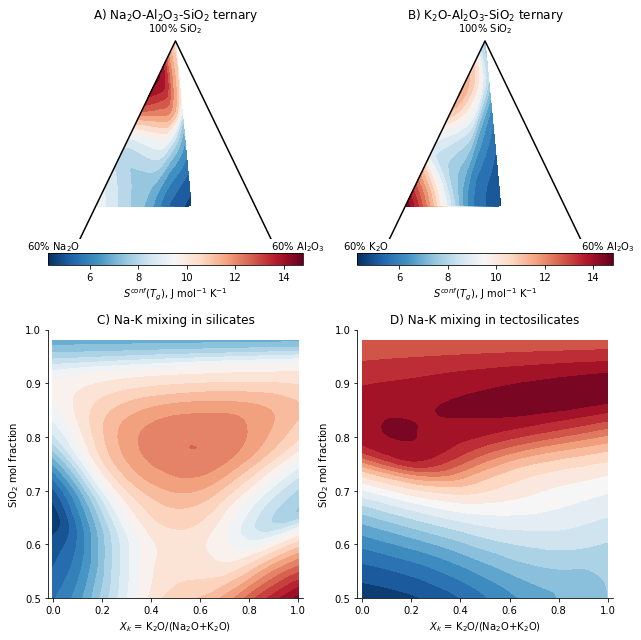

In [90]:
plt.figure(figsize=(9,9))

# grabing the entropies along NS/KS
sctg_NAS = neuralmodel.predict("sctg",X_gen_NAS).mean(axis=1)
sctg_KAS = neuralmodel.predict("sctg",X_gen_KAS).mean(axis=1)
sctg_all = neuralmodel.predict("sctg",X_gen_all).mean(axis=1)

# grabing the entropies for the mixtures
sctg_RS_Xk = neuralmodel.predict("sctg",X_gen_RS_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)
sctg_R3_Xk = neuralmodel.predict("sctg",X_gen_R3_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)
sctg_R1_Xk = neuralmodel.predict("sctg",X_gen_R1_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)

trig_color_plot = sctg_all # for the colors > same scale 

# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.
norm = matplotlib.colors.Normalize(
    vmin=np.min(trig_color_plot),
    vmax=np.max(trig_color_plot))

c_m = matplotlib.cm.RdBu_r # choose a colormap
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm) # create a ScalarMappable and initialize a data structure

####
#### TERNARY PLOT NAS
####
ax= plt.subplot(2,2,1)
tc1 = plt.tricontourf(cart_NAS[:,0], 
                cart_NAS[:,1], 
                sctg_NAS, 
                levels=20, cmap="RdBu_r")

#ax.scatter(cart_NAS[:,0],cart_NAS[:,1],s=1,c="k", cmap="RdBu_r")
ax.plot([0,1,2,0],[0,1,0,0],"k-")

ax.set_xlim(0.2,1.8)
ax.set_ylim(0.4,1.05)

plt.annotate(r"100% SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"60% Al$_2$O$_3$", xy = (1.6,0.4),xycoords="data",ha="left",va="top")
plt.annotate(r"60% Na$_2$O", xy = (0.4,0.4),xycoords="data",ha="right",va="top")

ax.axis("off")

cbar_0 = plt.colorbar(mappable=s_m,orientation="horizontal",pad=0.05)
cbar_0.set_label(r"$S^{conf}(T{_g})$, J mol$^{-1}$ K$^{-1}$")

ax.set_title("A) Na$_2$O-Al$_2$O$_3$-SiO$_2$ ternary", loc='center')

plt.tight_layout()

####
#### TERNARY PLOT KAS
####
ax= plt.subplot(2,2,2)
tc1 = plt.tricontourf(cart_KAS[:,0], 
                cart_KAS[:,1], 
                sctg_KAS, 
                levels=20, cmap="RdBu_r")

#ax.scatter(cart_NAS[:,0],cart_NAS[:,1],s=1,c="k", cmap="RdBu_r")
ax.plot([0,1,2,0],[0,1,0,0],"k-")

ax.set_xlim(0.2,1.8)
ax.set_ylim(0.4,1.05)

plt.annotate(r"100% SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"60% Al$_2$O$_3$", xy = (1.6,0.4),xycoords="data",ha="left",va="top")
plt.annotate(r"60% K$_2$O", xy = (0.4,0.4),xycoords="data",ha="right",va="top")

ax.axis("off")
 
cbar_0 = plt.colorbar(mappable=s_m,orientation="horizontal",pad=0.05)
cbar_0.set_label(r"$S^{conf}(T{_g})$, J mol$^{-1}$ K$^{-1}$")

ax.set_title("B) K$_2$O-Al$_2$O$_3$-SiO$_2$ ternary", loc='center')

plt.tight_layout()

####
#### XK along near tectosilicate joint
####
ax= plt.subplot(2,2,3)
tc1 = plt.tricontourf(X_gen_RS_Xk_rec.loc[:,"xk"], 
                X_gen_RS_Xk_rec.loc[:,"sio2"], 
                sctg_RS_Xk, 
                levels=20, cmap="RdBu_r")

#ax.scatter(cart_KAS[:,0],cart_KAS[:,1],s=1,c="k", cmap="RdBu_r")
ax.set_xlim(-0.02,1.02)
ax.set_ylim(0.5,1.)

plt.xlabel(r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)")
plt.ylabel(r"SiO$_2$ mol fraction")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#ax.axis('off') 
#cbar_0 = plt.colorbar(mappable=s_m,orientation="horizontal",pad=0.05)
#cbar_0.set_label(r"$S^{conf}(T{_g})$, J mol$^{-1}$ K$^{-1}$")

ax.set_title("C) Na-K mixing in silicates", loc='center')

plt.tight_layout()

####
#### XK along near tectosilicate joint
####
ax= plt.subplot(2,2,4)
tc1 = plt.tricontourf(X_gen_R1_Xk_rec.loc[:,"xk"], 
                X_gen_R1_Xk_rec.loc[:,"sio2"], 
                sctg_R1_Xk, 
                levels=20, cmap="RdBu_r")

#ax.scatter(cart_KAS[:,0],cart_KAS[:,1],s=1,c="k", cmap="RdBu_r")
ax.set_xlim(-0.02,1.02)
ax.set_ylim(0.5,1.)

plt.xlabel(r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)")
plt.ylabel(r"SiO$_2$ mol fraction")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#cbar_0 = plt.colorbar(mappable=s_m,orientation="vertical",pad=0.05)
#cbar_0.set_label(r"$S^{conf}(T{_g})$, J mol$^{-1}$ K$^{-1}$")

ax.set_title("D) Na-K mixing in tectosilicates", loc='center')

plt.tight_layout()

plt.savefig("./figures/Figure3_entromaps.png")

# Maps of glass properties: Tg, density, refractive index

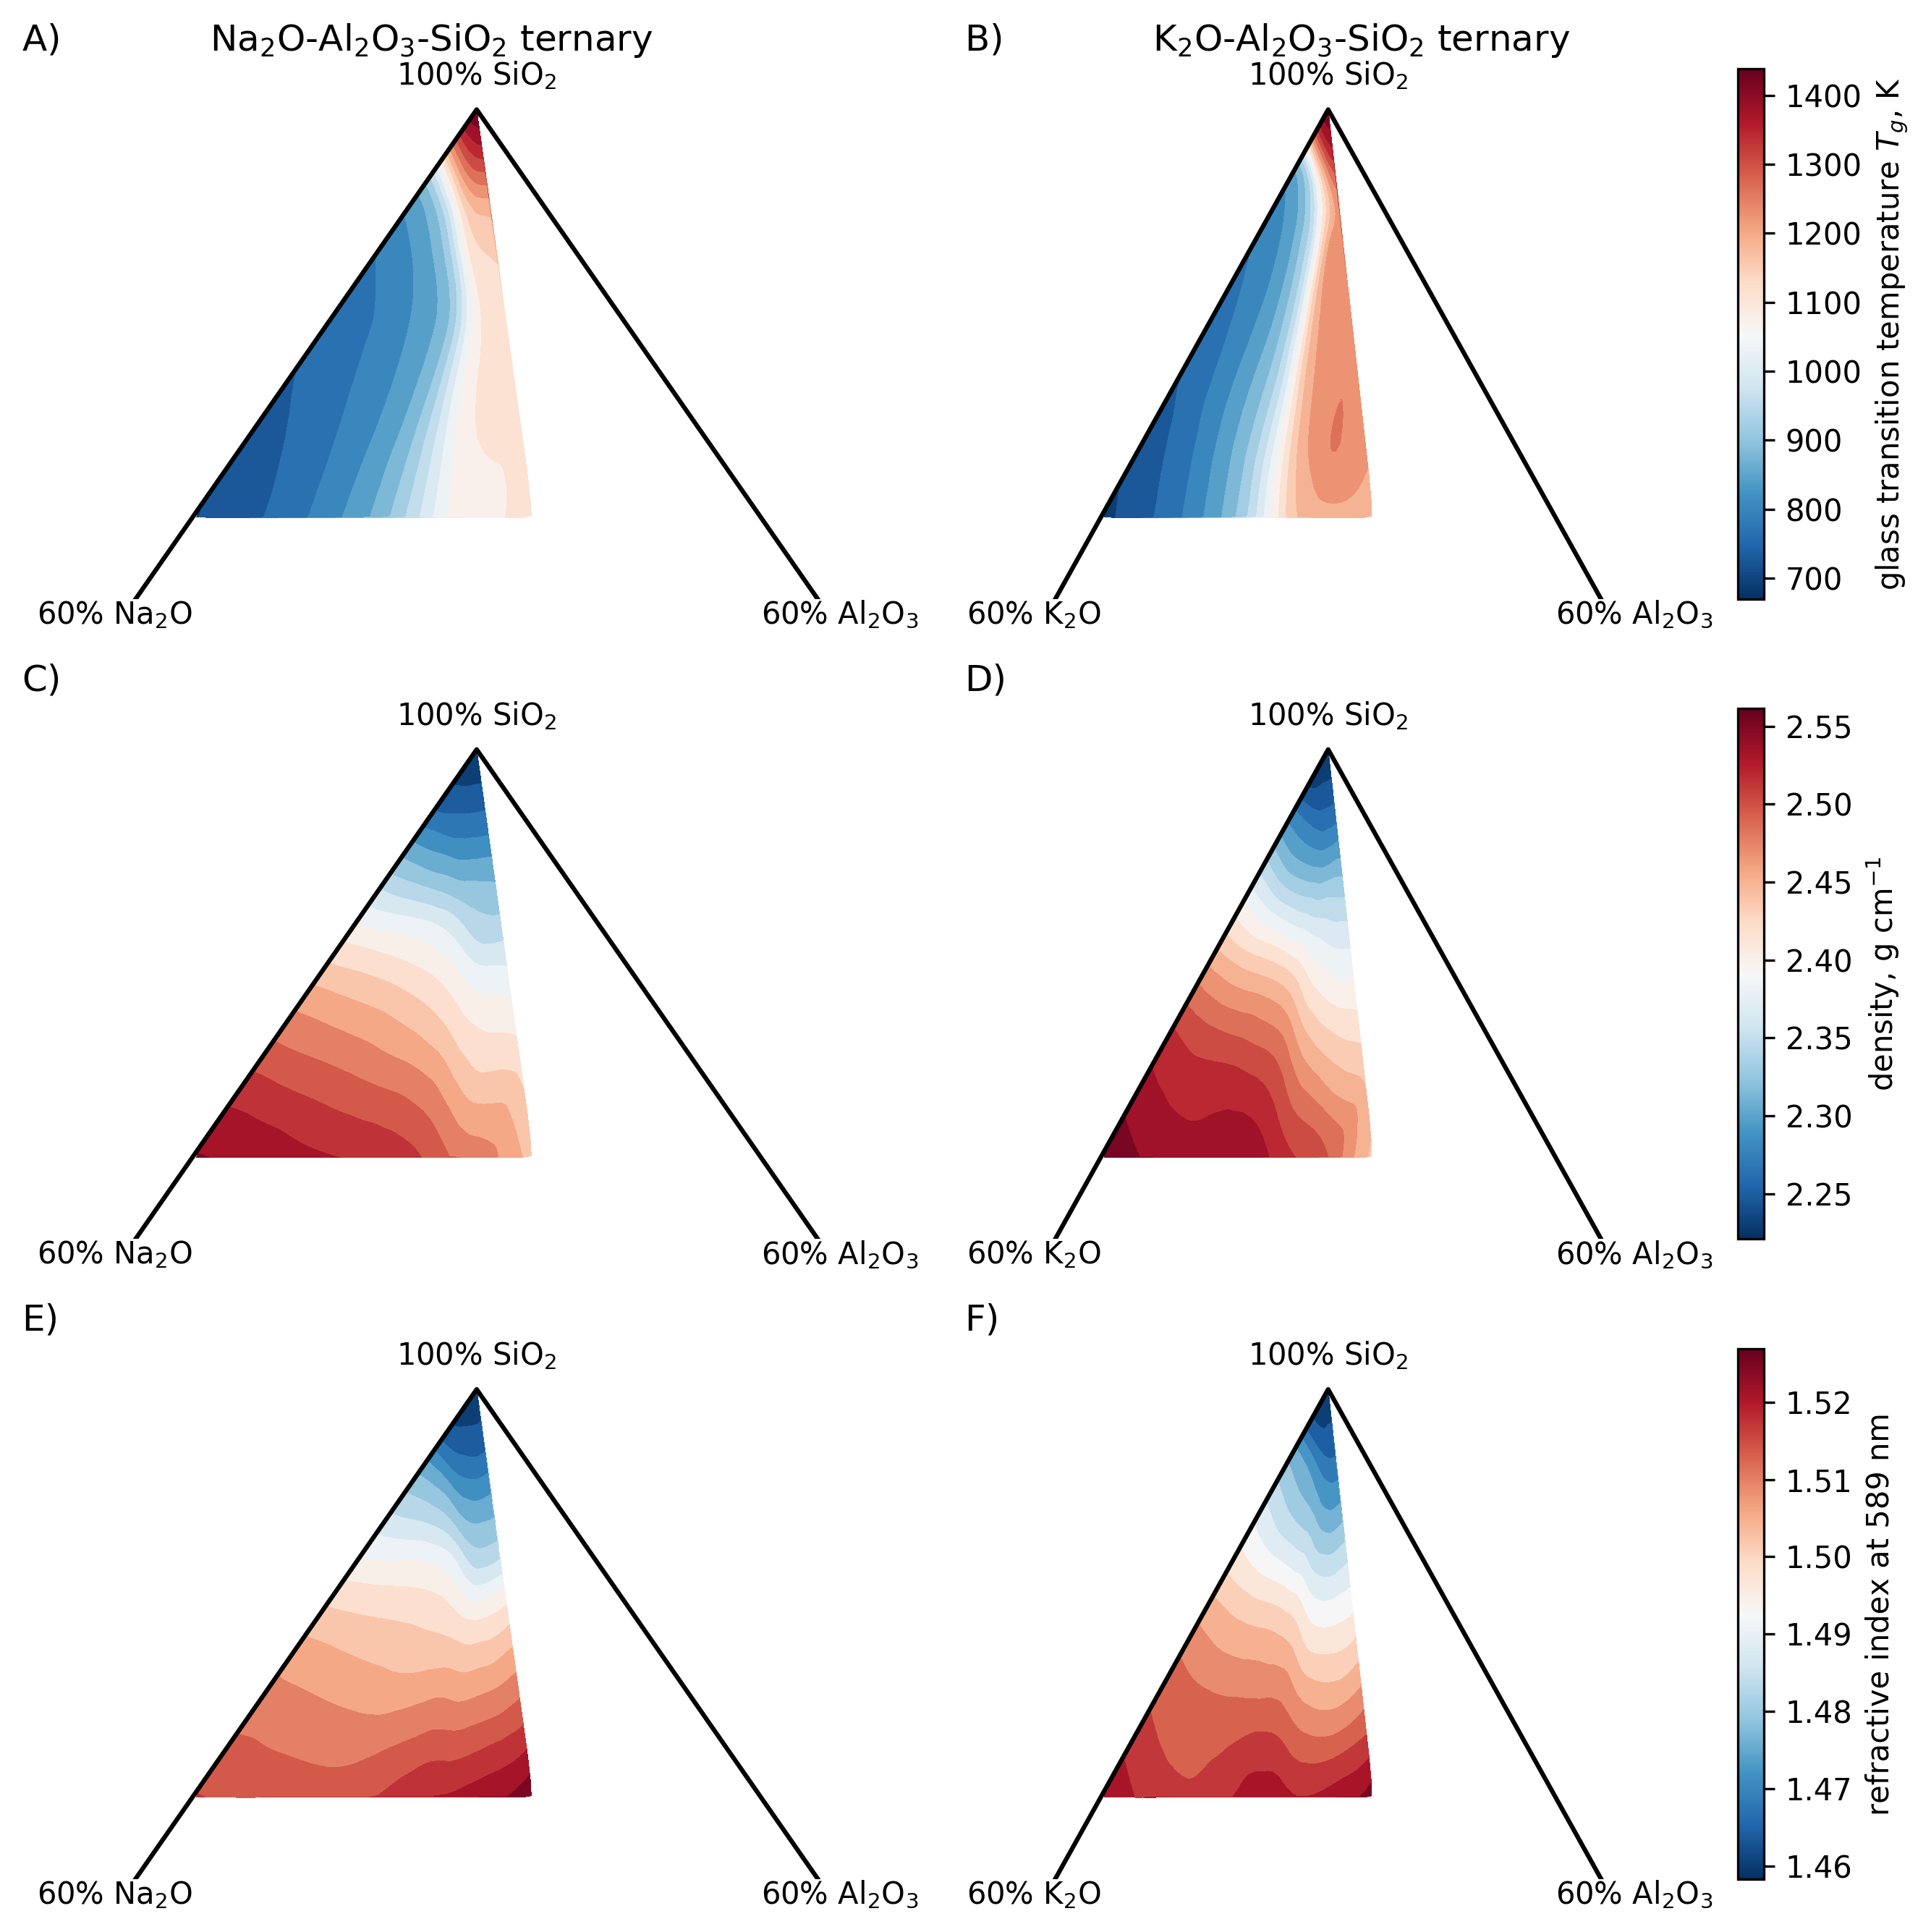

In [91]:
plt.figure(figsize=(9,9), dpi=300)

# grabing the predictions in NAS and KAS
tg_NAS = neuralmodel.predict("tg",X_gen_NAS).mean(axis=1)
tg_KAS = neuralmodel.predict("tg",X_gen_KAS).mean(axis=1)
tg_all = neuralmodel.predict("tg",X_gen_all).mean(axis=1)

d_NAS = neuralmodel.predict("density",X_gen_NAS).mean(axis=1)
d_KAS = neuralmodel.predict("density",X_gen_KAS).mean(axis=1)
d_all = neuralmodel.predict("density",X_gen_all).mean(axis=1)

n_NAS = neuralmodel.predict("sellmeier",X_gen_NAS,lbd=np.ones((len(X_gen_NAS),1))*0.589).mean(axis=1)
n_KAS = neuralmodel.predict("sellmeier",X_gen_KAS,lbd=np.ones((len(X_gen_KAS),1))*0.589).mean(axis=1)
n_all = neuralmodel.predict("sellmeier",X_gen_all,lbd=np.ones((len(X_gen_all),1))*0.589).mean(axis=1)

# choose a colormap
c_m = matplotlib.cm.RdBu_r 

#### Scalar Mappables for color bars
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, 
                                   norm=matplotlib.colors.Normalize(
                                                                    vmin=np.min(tg_all),
                                                                    vmax=np.max(tg_all))) # create a ScalarMappable and initialize a data structure
s_d = matplotlib.cm.ScalarMappable(cmap=c_m, 
                                   norm=matplotlib.colors.Normalize(
                                                                    vmin=np.min(d_all),
                                                                    vmax=np.max(d_all))) # create a ScalarMappable and initialize a data structure

s_n = matplotlib.cm.ScalarMappable(cmap=c_m, 
                                   norm=matplotlib.colors.Normalize(
                                                                    vmin=np.min(n_all),
                                                                    vmax=np.max(n_all))) # create a ScalarMappable and initialize a data structure

####
#### NAS Tg TERNARY PLOT
####
ax= plt.subplot(3,2,1)

tc1 = plt.tricontourf(cart_NAS[:,0], cart_NAS[:,1], tg_NAS, levels=20, cmap="RdBu_r")
ax.plot([0,1,2,0],[0,1,0,0],"k-")
#cbar_0 = plt.colorbar(mappable=s_m,orientation="horizontal",pad=0.05)
#cbar_0.set_label(r"fragility $m$")

ax.axis("off")
ax.set_xlim(0.2,1.8)
ax.set_ylim(0.4,1.05)

plt.annotate(r"100% SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"60% Al$_2$O$_3$", xy = (1.5,0.4),xycoords="data",ha="left",va="top")
plt.annotate(r"60% Na$_2$O", xy = (0.5,0.4),xycoords="data",ha="right",va="top")
ax.set_title("A)             Na$_2$O-Al$_2$O$_3$-SiO$_2$ ternary", loc='left')

plt.tight_layout()

####
#### KAS Tg TERNARY PLOT
####
ax= plt.subplot(3,2,2)

tc1 = plt.tricontourf(cart_KAS[:,0], cart_KAS[:,1], tg_KAS, levels=20, cmap="RdBu_r")
ax.plot([0,1,2,0],[0,1,0,0],"k-")
cbar_0 = plt.colorbar(mappable=s_m,orientation="vertical",pad=0.05)
cbar_0.set_label(r"glass transition temperature $T_{g}$, K")

ax.axis("off")
ax.set_xlim(0.2,1.8)
ax.set_ylim(0.4,1.05)

plt.annotate(r"100% SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"60% Al$_2$O$_3$", xy = (1.5,0.4),xycoords="data",ha="left",va="top")
plt.annotate(r"60% K$_2$O", xy = (0.5,0.4),xycoords="data",ha="right",va="top")
ax.set_title("B)             K$_2$O-Al$_2$O$_3$-SiO$_2$ ternary", loc='left')

plt.tight_layout()

####
#### NAS DENSITY TERNARY PLOT
####
ax= plt.subplot(3,2,3)
tc1 = plt.tricontourf(cart_NAS[:,0], cart_NAS[:,1], d_NAS, levels=20, cmap="RdBu_r")
ax.plot([0,1,2,0],[0,1,0,0],"k-")
#cbar_0 = plt.colorbar(mappable=s_d,orientation="horizontal",pad=0.05)
#cbar_0.set_label(r"density, g cm$^{-1}$")

ax.axis("off")
ax.set_xlim(0.2,1.8)
ax.set_ylim(0.4,1.05)

plt.annotate(r"100% SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"60% Al$_2$O$_3$", xy = (1.5,0.4),xycoords="data",ha="left",va="top")
plt.annotate(r"60% Na$_2$O", xy = (0.5,0.4),xycoords="data",ha="right",va="top")
ax.set_title("C)", loc='left')

plt.tight_layout()

####
#### KAS DENSITY TERNARY PLOT
####
ax= plt.subplot(3,2,4)
tc1 = plt.tricontourf(cart_KAS[:,0], cart_KAS[:,1], d_KAS, levels=20, cmap="RdBu_r")
ax.plot([0,1,2,0],[0,1,0,0],"k-")
cbar_0 = plt.colorbar(mappable=s_d,orientation="vertical",pad=0.05)
cbar_0.set_label(r"density, g cm$^{-1}$")

ax.axis("off")
ax.set_xlim(0.2,1.8)
ax.set_ylim(0.4,1.05)

plt.annotate(r"100% SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"60% Al$_2$O$_3$", xy = (1.5,0.4),xycoords="data",ha="left",va="top")
plt.annotate(r"60% K$_2$O", xy = (0.5,0.4),xycoords="data",ha="right",va="top")
ax.set_title("D)", loc='left')

plt.tight_layout()

####
#### NAS OPTIC TERNARY PLOT
####
ax= plt.subplot(3,2,5)
tc1 = plt.tricontourf(cart_NAS[:,0], cart_NAS[:,1], n_NAS, levels=20, cmap="RdBu_r")
ax.plot([0,1,2,0],[0,1,0,0],"k-")
#cbar_0 = plt.colorbar(mappable=s_n,orientation="horizontal",pad=0.05)
#cbar_0.set_label(r"m")

ax.axis("off")
ax.set_xlim(0.2,1.8)
ax.set_ylim(0.4,1.05)

plt.annotate(r"100% SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"60% Al$_2$O$_3$", xy = (1.5,0.4),xycoords="data",ha="left",va="top")
plt.annotate(r"60% Na$_2$O", xy = (0.5,0.4),xycoords="data",ha="right",va="top")
ax.set_title("E)", loc='left')

plt.tight_layout()

####
#### KAS FRAGILITY TERNARY PLOT
####
ax= plt.subplot(3,2,6)
tc1 = plt.tricontourf(cart_KAS[:,0], cart_KAS[:,1], n_KAS, levels=20, cmap="RdBu_r")
ax.plot([0,1,2,0],[0,1,0,0],"k-")
cbar_0 = plt.colorbar(mappable=s_n,orientation="vertical",pad=0.05)
cbar_0.set_label(r"refractive index at 589 nm")

ax.axis("off")
ax.set_xlim(0.2,1.8)
ax.set_ylim(0.4,1.05)

plt.annotate(r"100% SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"60% Al$_2$O$_3$", xy = (1.5,0.4),xycoords="data",ha="left",va="top")
plt.annotate(r"60% K$_2$O", xy = (0.5,0.4),xycoords="data",ha="right",va="top")

ax.set_title("F)", loc='left')

plt.tight_layout()

plt.savefig("./figures/Figure4_Tg_maps.png")

# Map for fragility vs XK

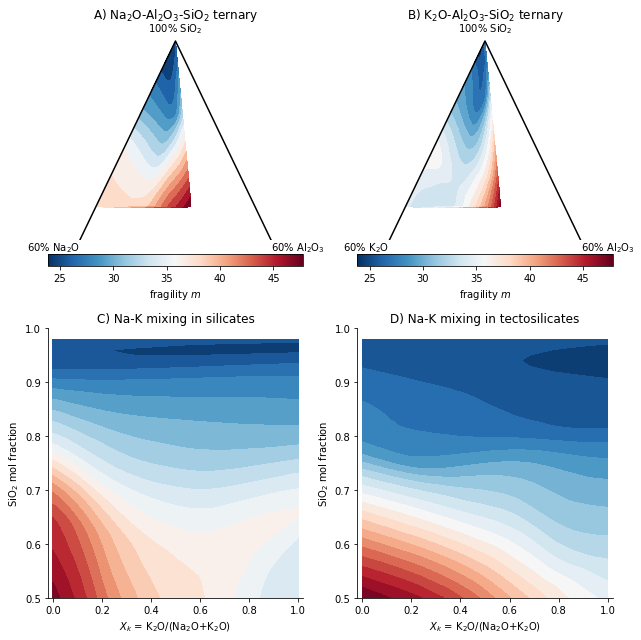

In [93]:
plt.figure(figsize=(9,9))

# grabing the entropies along NS/KS
fragility_NAS = neuralmodel.predict("fragility",X_gen_NAS).mean(axis=1)
fragility_KAS = neuralmodel.predict("fragility",X_gen_KAS).mean(axis=1)
fragility_all = neuralmodel.predict("fragility",X_gen_all).mean(axis=1)

# grabing the entropies for the mixtures
fragility_RS_Xk = neuralmodel.predict("fragility",X_gen_RS_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)
fragility_R3_Xk = neuralmodel.predict("fragility",X_gen_R3_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)
fragility_R1_Xk = neuralmodel.predict("fragility",X_gen_R1_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).mean(axis=1)

trig_color_plot = fragility_all # for the colors > same scale 

# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.
norm = matplotlib.colors.Normalize(
    vmin=np.min(trig_color_plot),
    vmax=np.max(trig_color_plot))

c_m = matplotlib.cm.RdBu_r # choose a colormap
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm) # create a ScalarMappable and initialize a data structure

####
#### TERNARY PLOT NAS
####
ax= plt.subplot(2,2,1)
tc1 = plt.tricontourf(cart_NAS[:,0], 
                cart_NAS[:,1], 
                fragility_NAS, 
                levels=20, cmap="RdBu_r")

#ax.scatter(cart_NAS[:,0],cart_NAS[:,1],s=1,c="k", cmap="RdBu_r")
ax.plot([0,1,2,0],[0,1,0,0],"k-")

ax.set_xlim(0.2,1.8)
ax.set_ylim(0.4,1.05)

plt.annotate(r"100% SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"60% Al$_2$O$_3$", xy = (1.6,0.4),xycoords="data",ha="left",va="top")
plt.annotate(r"60% Na$_2$O", xy = (0.4,0.4),xycoords="data",ha="right",va="top")

ax.axis("off")

cbar_0 = plt.colorbar(mappable=s_m,orientation="horizontal",pad=0.05)
cbar_0.set_label(r"fragility $m$")

ax.set_title("A) Na$_2$O-Al$_2$O$_3$-SiO$_2$ ternary", loc='center')

plt.tight_layout()

####
#### TERNARY PLOT KAS
####
ax= plt.subplot(2,2,2)
tc1 = plt.tricontourf(cart_KAS[:,0], 
                cart_KAS[:,1], 
                fragility_KAS, 
                levels=20, cmap="RdBu_r")

#ax.scatter(cart_NAS[:,0],cart_NAS[:,1],s=1,c="k", cmap="RdBu_r")
ax.plot([0,1,2,0],[0,1,0,0],"k-")

ax.set_xlim(0.2,1.8)
ax.set_ylim(0.4,1.05)

plt.annotate(r"100% SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"60% Al$_2$O$_3$", xy = (1.6,0.4),xycoords="data",ha="left",va="top")
plt.annotate(r"60% K$_2$O", xy = (0.4,0.4),xycoords="data",ha="right",va="top")

ax.axis("off")
 
cbar_0 = plt.colorbar(mappable=s_m,orientation="horizontal",pad=0.05)
cbar_0.set_label(r"fragility $m$")

ax.set_title("B) K$_2$O-Al$_2$O$_3$-SiO$_2$ ternary", loc='center')

plt.tight_layout()

####
#### XK along near tectosilicate joint
####
ax= plt.subplot(2,2,3)
tc1 = plt.tricontourf(X_gen_RS_Xk_rec.loc[:,"xk"], 
                X_gen_RS_Xk_rec.loc[:,"sio2"], 
                fragility_RS_Xk, 
                levels=20, cmap="RdBu_r")

#ax.scatter(cart_KAS[:,0],cart_KAS[:,1],s=1,c="k", cmap="RdBu_r")
ax.set_xlim(-0.02,1.02)
ax.set_ylim(0.5,1.)

plt.xlabel(r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)")
plt.ylabel(r"SiO$_2$ mol fraction")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#ax.axis('off') 
#cbar_0 = plt.colorbar(mappable=s_m,orientation="horizontal",pad=0.05)
#cbar_0.set_label(r"$S^{conf}(T{_g})$, J mol$^{-1}$ K$^{-1}$")

ax.set_title("C) Na-K mixing in silicates", loc='center')

plt.tight_layout()

####
#### XK along near tectosilicate joint
####
ax= plt.subplot(2,2,4)
tc1 = plt.tricontourf(X_gen_R1_Xk_rec.loc[:,"xk"], 
                X_gen_R1_Xk_rec.loc[:,"sio2"], 
                fragility_R1_Xk, 
                levels=20, cmap="RdBu_r")

#ax.scatter(cart_KAS[:,0],cart_KAS[:,1],s=1,c="k", cmap="RdBu_r")
ax.set_xlim(-0.02,1.02)
ax.set_ylim(0.5,1.)

plt.xlabel(r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)")
plt.ylabel(r"SiO$_2$ mol fraction")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#cbar_0 = plt.colorbar(mappable=s_m,orientation="vertical",pad=0.05)
#cbar_0.set_label(r"$S^{conf}(T{_g})$, J mol$^{-1}$ K$^{-1}$")

ax.set_title("D) Na-K mixing in tectosilicates", loc='center')

plt.tight_layout()

plt.savefig("./figures/Supplementary_fragility.png")